In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
import os
import plotly
import plotly.graph_objs as go
import time
import itertools
import cv2
import seaborn as sns
import warnings
import tqdm
import math

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
plotly.offline.init_notebook_mode(True)

dataset_dir = 'C:\Traffic Signs'
meta_info = os.path.join(dataset_dir, 'Meta.csv')
#meta_info = dataset_dir + '/Meta.csv'
#train_csv_path = dataset_dir + '/Train.csv'
#test_csv_path = dataset_dir + '/Test.csv'
train_csv_path = os.path.join(dataset_dir, 'Train.csv')
test_csv_path = os.path.join(dataset_dir, 'Test.csv')
labels = ['20 km/h', '30 km/h', '50 km/h', '60 km/h', '70 km/h', '80 km/h', '80 km/h end', '100 km/h', '120 km/h', 'No overtaking',
               'No overtaking for tracks', 'Crossroad with secondary way', 'Main road', 'Give way', 'Stop', 'Road up', 'Road up for track', 'Brock',
               'Other dangerous', 'Turn left', 'Turn right', 'Winding road', 'Hollow road', 'Slippery road', 'Narrowing road', 'Roadwork', 'Traffic light',
               'Pedestrian', 'Children', 'Bike', 'Snow', 'Deer', 'End of the limits', 'Only right', 'Only left', 'Only straight', 'Only straight and right', 
               'Only straight and left', 'Take right', 'Take left', 'Circle crossroad', 'End of overtaking limit', 'End of overtaking limit for track']



In [27]:
len(labels)

43

In [3]:
train_data_color = '#0f7b8e'
test_data_color = '#630f8e'

trainDf = pd.read_csv(train_csv_path)
testDf = pd.read_csv(test_csv_path)
metaDf = pd.read_csv(meta_info)

trainDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x.lower()), trainDf['Path']))
testDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x.lower()), testDf['Path']))
metaDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x.lower()), metaDf['Path']))

trainDf.sample(3)

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
36773     48      46       6       5      43      41       38   
22655     37      37       6       6      32      32       14   
5560      44      43       6       5      39      38        3   

                                                  Path  
36773  C:\Traffic Signs\train/38/00038_00025_00024.png  
22655  C:\Traffic Signs\train/14/00014_00001_00005.png  
5560    C:\Traffic Signs\train/3/00003_00017_00010.png

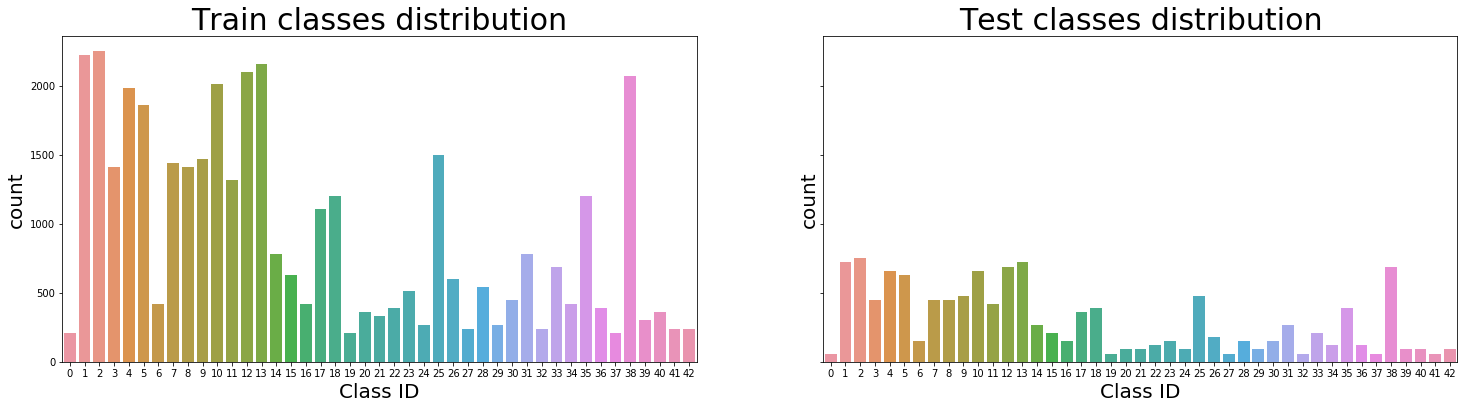

In [9]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(25, 6))
axs[0].set_title('Train classes distribution', fontsize=30)
axs[0].set_xlabel('Class', fontsize=20)
axs[0].set_ylabel('Count', fontsize=20)
axs[1].set_title('Test classes distribution', fontsize=30)
axs[1].set_xlabel('Class', fontsize=20)
axs[1].set_ylabel('Count', fontsize=20)

sns.countplot(trainDf.ClassId, ax=axs[0])
sns.countplot(testDf.ClassId, ax=axs[1])
axs[0].set_xlabel('Class ID');
axs[1].set_xlabel('Class ID');

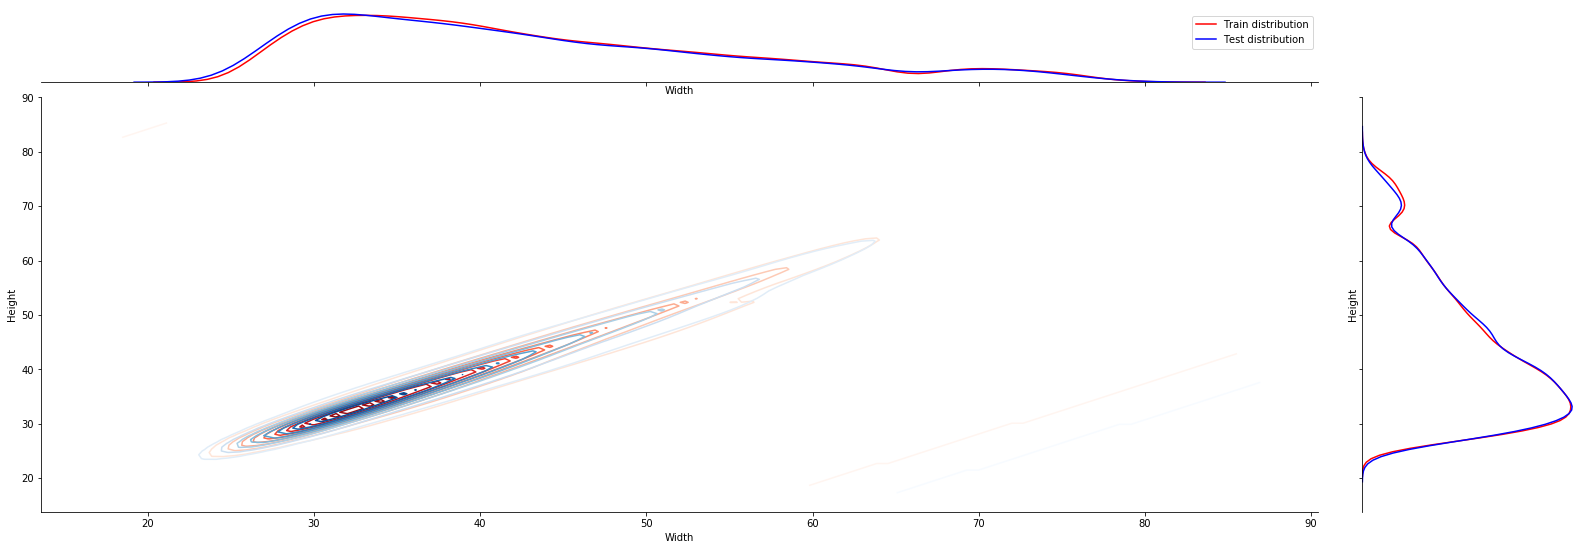

In [6]:
trainDfDpiSubset = trainDf[(trainDf.Width < 80) & (trainDf.Height < 80)];
testDfDpiSubset = testDf[(testDf.Width < 80) & (testDf.Height < 80)];

g = sns.JointGrid(x="Width", y="Height", data=trainDfDpiSubset)
sns.kdeplot(trainDfDpiSubset.Width, trainDfDpiSubset.Height, cmap="Reds",
        shade=False, shade_lowest=False, ax=g.ax_joint)
sns.kdeplot(testDfDpiSubset.Width, testDfDpiSubset.Height, cmap="Blues",
        shade=False, shade_lowest=False, ax=g.ax_joint)
sns.distplot(trainDfDpiSubset.Width, kde=True, hist=False, color="r", ax=g.ax_marg_x, label='Train distribution')
sns.distplot(testDfDpiSubset.Width, kde=True, hist=False, color="b", ax=g.ax_marg_x, label='Test distribution')
sns.distplot(trainDfDpiSubset.Width, kde=True, hist=False, color="r", ax=g.ax_marg_y, vertical=True)
sns.distplot(testDfDpiSubset.Height, kde=True, hist=False, color="b", ax=g.ax_marg_y, vertical=True)
g.fig.set_figwidth(25)
g.fig.set_figheight(8)
plt.show();

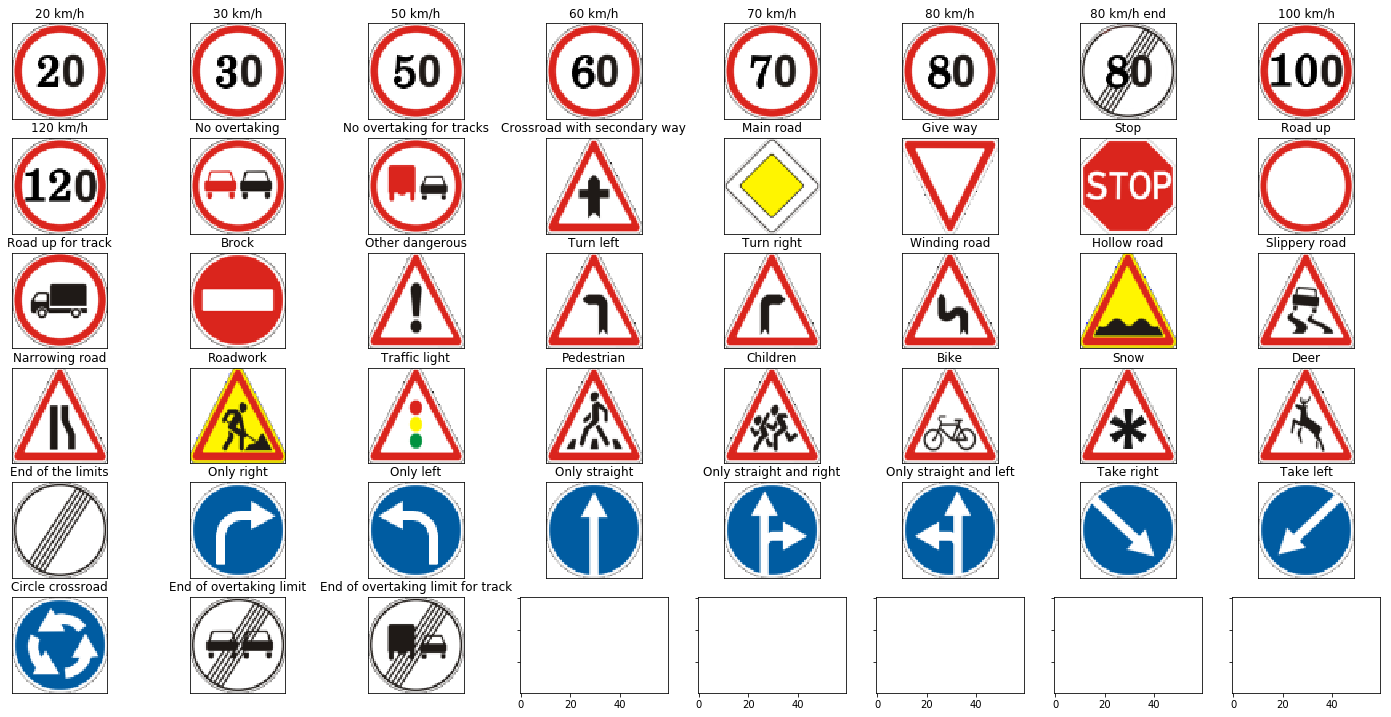

In [10]:
sns.set_style()
rows = 6
cols = 8
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)
metaDf = metaDf.sort_values(by=['ClassId'])

idx = 0
for i in range(rows):
    for j in range(cols):
        if idx > 42:
            break
            
        img = cv2.imread(metaDf["Path"].tolist()[idx], cv2.IMREAD_UNCHANGED)
        img[np.where(img[:,:,3]==0)] = [255,255,255,255]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (60,60))
        
        axs[i,j].imshow(img)
        axs[i,j].set_facecolor('xkcd:salmon')
        axs[i,j].set_facecolor((1.0, 0.47, 0.42))
        axs[i,j].set_title(labels[int(metaDf["ClassId"].tolist()[idx])])
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1

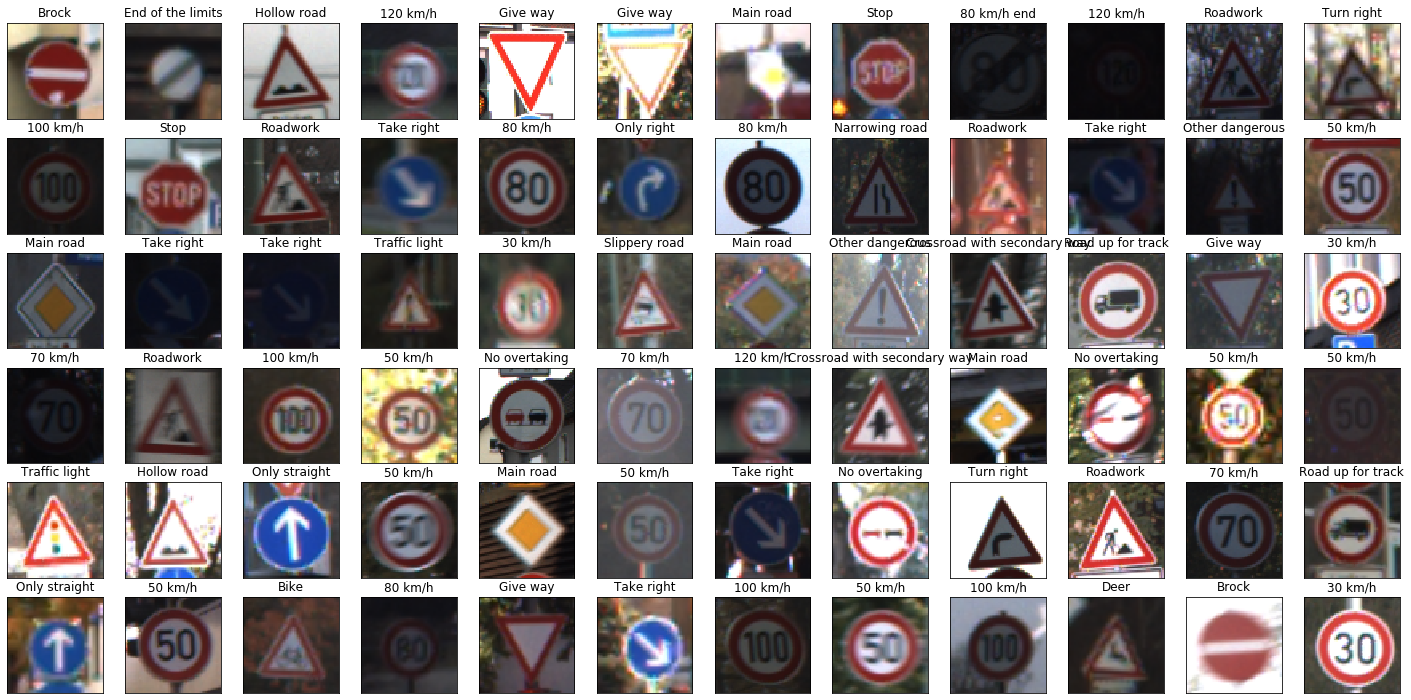

In [11]:
rows = 6
cols = 8+4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)
visualize = trainDf.sample(rows*cols)

idx = 0
for i in range(rows):
    for j in range(cols):
        img = cv2.imread(visualize["Path"].tolist()[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (60,60))
        axs[i,j].imshow(img)
        axs[i,j].set_title(labels[int(visualize["ClassId"].tolist()[idx])])
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1

In [4]:
img_load_size = (60,60)
zero_img = np.zeros([12,img_load_size[0], img_load_size[1], 3])
zero_label = np.zeros([12,1])

def parse_function(filename, label):
        image_string = tf.read_file(filename)
        image = tf.image.decode_jpeg(image_string, channels=3)
#         image = tf.py_func(eq, [image], image.dtype)
        image.set_shape([None, None, 3])
        
        return filename, image, label
    
def train_preprocess(filename, image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_images(image, img_load_size)
    return filename, image, label

def augmentate(filename, image, label):
    grad = tf.random.uniform(shape=[], minval=-0.3, maxval=0.3)
    dx = tf.random.uniform(shape=[], minval=-15, maxval=15, dtype=tf.int32)
    dy = tf.random.uniform(shape=[], minval=-15, maxval=15, dtype=tf.int32)
    image = tf.contrib.image.rotate(image, grad)
    image = tf.contrib.image.translate(image, translations=[dx, dy])
    
    return filename, image, label

def eq(img: np.ndarray):
    res = img.copy()
    res[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    res[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    res[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    
    return res

def tf_equalize_histogram(image):
    values_range = tf.constant([0., 255.], dtype = tf.float32)
    histogram = tf.histogram_fixed_width(tf.to_float(image), values_range, 256)
    cdf = tf.cumsum(histogram)
    cdf_min = cdf[tf.reduce_min(tf.where(tf.greater(cdf, 0)))]

    img_shape = tf.shape(image)
    pix_cnt = img_shape[-3] * img_shape[-2]
    px_map = tf.round(tf.to_float(cdf - cdf_min) * 255. / tf.to_float(pix_cnt - 1))
    px_map = tf.cast(px_map, tf.uint8)

    gth = tf.gather_nd(px_map, tf.cast(image, tf.int32))
    eq_hist = tf.expand_dims(gth, 2)
    return image

In [5]:
tf.reset_default_graph()

epochs = 10
batch_size = 12
prefetch_count = 1
samples_train = len(trainDf)
samples_test = len(testDf)

dataset_train = tf.data.Dataset.from_tensor_slices((trainDf['Path'], trainDf['ClassId']))
dataset_train = dataset_train.shuffle(len(trainDf['Path']))
dataset_train = dataset_train.repeat(epochs)
dataset_train = dataset_train.map(parse_function, num_parallel_calls=4)
dataset_train = dataset_train.map(train_preprocess, num_parallel_calls=4)
dataset_train = dataset_train.map(augmentate, num_parallel_calls=4)
dataset_train = dataset_train.batch(batch_size)
dataset_train = dataset_train.prefetch(prefetch_count)

dataset_iterator = tf.data.Iterator.from_structure(dataset_train.output_types,
                                                          dataset_train.output_shapes)


dataset_test = tf.data.Dataset.from_tensor_slices((testDf['Path'], testDf['ClassId']))
dataset_test = dataset_test.shuffle(len(testDf['Path']))
dataset_test = dataset_test.repeat(epochs+1)
dataset_test = dataset_test.map(parse_function, num_parallel_calls=4)
dataset_test = dataset_test.map(train_preprocess, num_parallel_calls=4)
dataset_test = dataset_test.batch(batch_size)
dataset_test = dataset_test.prefetch(prefetch_count)


train_init_op = dataset_iterator.make_initializer(dataset_train)
test_init_op = dataset_iterator.make_initializer(dataset_test)

load_filename, load_img, load_label = dataset_iterator.get_next()

W0412 18:22:03.607341  9488 module_wrapper.py:139] From C:\Users\jaski\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\autograph\converters\directives.py:119: The name tf.read_file is deprecated. Please use tf.io.read_file instead.

W0412 18:22:03.776248  9488 module_wrapper.py:139] From C:\Users\jaski\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\autograph\converters\directives.py:119: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.

W0412 18:22:03.927144  9488 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0412 18:22:04.512808  9488 deprecation.py:323] From <ipython-input-5-

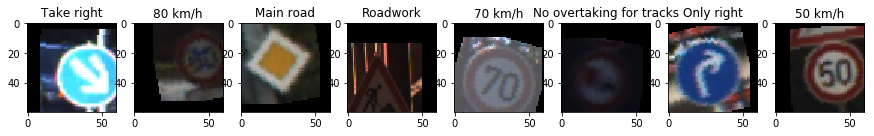

In [14]:
fig, ax = plt.subplots(ncols=8, nrows=1, figsize=(15, 6))
with tf.Session() as sess:
    sess.run(train_init_op)
    for j in range(8):
        i, l = sess.run([load_img, load_label])
        i = (i[0]*255).astype(np.uint8)
        ax[j].imshow(i)
        ax[j].set_title(labels[l[0]])

In [6]:
dp_rate = tf.placeholder(dtype=tf.float32, shape=[], name='dp_rate')

img_placeholder = tf.placeholder(shape=[None, 60,60,3], dtype=tf.float32, name='img_placeholder')
label_placeholder = tf.placeholder(shape=[None, 1], dtype=tf.int64, name='label_placeholder')
manual_load = tf.placeholder(dtype=tf.bool, shape=[], name='manual_load_placeholder')

# inp = net = tf.cond(pred=manual_load, true_fn=lambda : img_placeholder, false_fn=lambda : load_img, name='network_start')
# label = tf.cond(pred=manual_load, true_fn=lambda : label_placeholder, false_fn=lambda : load_label, name='label')

inp = net = tf.cond(manual_load, lambda: img_placeholder, lambda: load_img)
label = load_label

conv1 = net = tf.layers.conv2d(inputs=net, filters=16, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
net = tf.layers.batch_normalization(inputs=net)
conv2 = net = tf.layers.conv2d(inputs=net, filters=32, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
net = tf.layers.batch_normalization(inputs=net)

conv3 = net = tf.layers.conv2d(inputs=net, filters=32, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
net = tf.layers.batch_normalization(inputs=net)
conv4 = net = tf.layers.conv2d(inputs=net, filters=64, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
net = tf.layers.batch_normalization(inputs=net)

net = tf.layers.max_pooling2d(inputs=net, pool_size=(2,2), strides=(2,2))

conv5 = net = tf.layers.conv2d(inputs=net, filters=64, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
net = tf.layers.batch_normalization(inputs=net)
conv6 = net = tf.layers.conv2d(inputs=net, filters=128, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
net = tf.layers.batch_normalization(inputs=net)

conv5 = net = tf.layers.conv2d(inputs=net, filters=256, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
net = tf.layers.batch_normalization(inputs=net)
conv6 = net = tf.layers.conv2d(inputs=net, filters=400, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
net = tf.layers.batch_normalization(inputs=net)

flatten1 = net = tf.layers.flatten(inputs=net)

dp1 = net = tf.layers.dropout(inputs=net, rate=dp_rate)
dense1 = net = tf.layers.dense(inputs=net, units=256)
logits = tf.layers.dense(inputs=net, units=43)

pred_classes = tf.argmax(logits, axis=1)
pred_probas = tf.nn.softmax(logits)

acc, acc_op = tf.metrics.accuracy(labels=label, predictions=pred_classes)
end_loss = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=label)

loss = end_loss

label_transpose = tf.transpose(label)
correct_prediction = tf.equal(pred_classes, label_transpose)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
confusion_matrix_op = tf.confusion_matrix(labels=label, predictions=pred_classes, num_classes=43)

opt = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

W0412 18:22:11.870485  9488 deprecation.py:323] From <ipython-input-6-a4c392cb2f06>:13: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0412 18:22:11.873502  9488 deprecation.py:323] From C:\Users\jaski\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\layers\convolutional.py:424: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
W0412 18:22:12.074300  9488 deprecation.py:323] From <ipython-input-6-a4c392cb2f06>:14: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.ke

In [16]:
tf.summary()

TypeError: 'TFModuleWrapper' object is not callable

In [7]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
sess = tf.Session(config=config)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
# irn.load_weights('inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5')
train_history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
best_acc = 0

In [8]:
import tensorflow.contrib.slim as slim
def model_summary():
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)

model_summary()

---------
Variables: name (type shape) [size]
---------
conv2d/kernel:0 (float32_ref 3x3x3x16) [432, bytes: 1728]
conv2d/bias:0 (float32_ref 16) [16, bytes: 64]
batch_normalization/gamma:0 (float32_ref 16) [16, bytes: 64]
batch_normalization/beta:0 (float32_ref 16) [16, bytes: 64]
conv2d_1/kernel:0 (float32_ref 3x3x16x32) [4608, bytes: 18432]
conv2d_1/bias:0 (float32_ref 32) [32, bytes: 128]
batch_normalization_1/gamma:0 (float32_ref 32) [32, bytes: 128]
batch_normalization_1/beta:0 (float32_ref 32) [32, bytes: 128]
conv2d_2/kernel:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
conv2d_2/bias:0 (float32_ref 32) [32, bytes: 128]
batch_normalization_2/gamma:0 (float32_ref 32) [32, bytes: 128]
batch_normalization_2/beta:0 (float32_ref 32) [32, bytes: 128]
conv2d_3/kernel:0 (float32_ref 3x3x32x64) [18432, bytes: 73728]
conv2d_3/bias:0 (float32_ref 64) [64, bytes: 256]
batch_normalization_3/gamma:0 (float32_ref 64) [64, bytes: 256]
batch_normalization_3/beta:0 (float32_ref 64) [64, bytes: 25

In [13]:
for e in range(epochs):
    epoch_history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
    
    sess.run(train_init_op)
    for i in tqdm.tqdm_notebook(range(samples_train//batch_size), ascii=True, desc='Train epoch {}'.format(e)):
        _, _loss, _acc, mn = sess.run([opt, loss, accuracy, inp], feed_dict={dp_rate: 0.3, manual_load: False, img_placeholder: zero_img, label_placeholder: zero_label})
#         print(np.mean(mn))
        epoch_history['loss'].append(_loss)
        epoch_history['acc'].append(_acc)
        
    sess.run(test_init_op)
    for i in tqdm.tqdm_notebook(range(samples_test//batch_size), ascii=True, desc='Test epoch {}'.format(e)):
        _loss, _acc = sess.run([loss, accuracy], feed_dict={dp_rate: 0, manual_load: False, img_placeholder: zero_img, label_placeholder: zero_label})
        epoch_history['val_loss'].append(_loss)
        epoch_history['val_acc'].append(_acc)
        
    train_history['loss'].append(np.mean(epoch_history['loss']))
    train_history['acc'].append(np.mean(epoch_history['acc']))
    train_history['val_loss'].append(np.mean(epoch_history['val_loss']))
    train_history['val_acc'].append(np.mean(epoch_history['val_acc']))
    
    print("***EPOCH SUMMARY*** Loss: {} Acc: {} | Test Loss: {} Test Acc {}".format(train_history['loss'][-1], train_history['acc'][-1],
                                                                                    train_history['val_loss'][-1], train_history['val_acc'][-1]))

    if train_history['val_acc'][-1] > best_acc:
        best_acc = train_history['val_acc'][-1]
        save_path = saver.save(sess, "./model.ckpt")
        print("Model saved in path: %s" % save_path)


***EPOCH SUMMARY*** Loss: 2.0489661693573 Acc: 0.3935057818889618 | Test Loss: 0.9334381222724915 Test Acc 0.6933618187904358
Model saved in path: ./model.ckpt



***EPOCH SUMMARY*** Loss: 0.6760098338127136 Acc: 0.7870115637779236 | Test Loss: 0.48060283064842224 Test Acc 0.8685044646263123
Model saved in path: ./model.ckpt



***EPOCH SUMMARY*** Loss: 0.31121593713760376 Acc: 0.904525101184845 | Test Loss: 0.3365877568721771 Test Acc 0.9210235476493835
Model saved in path: ./model.ckpt



***EPOCH SUMMARY*** Loss: 0.20490458607673645 Acc: 0.9388582706451416 | Test Loss: 0.3071591854095459 Test Acc 0.934965193271637
Model saved in path: ./model.ckpt



***EPOCH SUMMARY*** Loss: 0.1626320630311966 Acc: 0.950999915599823 | Test Loss: 0.2553769648075104 Test Acc 0.9334601163864136



***EPOCH SUMMARY*** Loss: 0.1292051523923874 Acc: 0.9616876244544983 | Test Loss: 0.18257351219654083 Test Acc 0.9496197700500488
Model saved in path: ./model.ckpt



***EPOCH SUMMARY*** Loss: 0.11506898701190948 Acc: 0.9678859710693359 | Test Loss: 0.4389924705028534 Test Acc 0.9241127967834473


KeyboardInterrupt: 

In [14]:
titlefont = dict(family='Courier New, monospace', size=18, color='#7f7f7f')
layout = go.Layout(title='Traing & Test loss', xaxis=dict(title='Epoch', titlefont=titlefont),
                                    yaxis=dict(title='Loss', titlefont=titlefont))
fig = go.Figure(data=[go.Scatter(y=train_history['loss'], name='Train loss'), go.Scatter(y=train_history['val_loss'], name='Test loss')], layout=layout)
plotly.offline.iplot(fig)

layout = go.Layout(title='Traing & Test accuracy', xaxis=dict(title='Epoch', titlefont=titlefont),
                                    yaxis=dict(title='Accuracy', titlefont=titlefont))
fig = go.Figure(data=[go.Scatter(y=train_history['acc'], name='Train accuracy'), go.Scatter(y=train_history['val_acc'], name='Test accuracy')], layout=layout)
plotly.offline.iplot(fig)

In [9]:
saver.restore(sess, "./model.ckpt")
sess.run(test_init_op)
confusion_matrix = np.zeros([43,43])
test_analys = trainDf.copy()
predictions = []
probabilities = []
analys = []

for i in tqdm.tqdm_notebook(range(samples_test//batch_size), ascii=True, desc='Test best model'):
    _files, _predictions, _probas, _gts, _cm = sess.run([load_filename, pred_classes, pred_probas, load_label, confusion_matrix_op], feed_dict={dp_rate: 0, manual_load: False, img_placeholder: zero_img, label_placeholder: zero_label})
    confusion_matrix += _cm
    for i in range(batch_size):
        sample_info = {'image': _files[i].decode(), 'prediction': int(_predictions[i]), 'gt': int(_gts[i]), 'gt_probas': _probas[i][_gts[i]],
                       'prediction_probas': _probas[i][_predictions[i]], 'prediction_type': 'Correct' if _gts[i] == _predictions[i] else 'Wrong'}
        for cls_id, j in enumerate(_probas[i]):
            sample_info['prob_{}'.format(cls_id)] = j
        analys.append(sample_info)

analys_df = pd.DataFrame(analys)

In [10]:
analys_df.sample(4)

gt  gt_probas                            image  prediction  \
6958   14   1.000000  C:\Traffic Signs\test/11477.png          14   
12022  15   0.840051  C:\Traffic Signs\test/09654.png          15   
10062  39   0.999998  C:\Traffic Signs\test/08056.png          39   
2534    2   0.999997  C:\Traffic Signs\test/07915.png           2   

       prediction_probas prediction_type        prob_0        prob_1  \
6958            1.000000         Correct  1.224767e-09  2.097716e-14   
12022           0.840051         Correct  1.708535e-06  1.594881e-06   
10062           0.999998         Correct  1.361819e-37  0.000000e+00   
2534            0.999997         Correct  5.830559e-10  1.809538e-12   

            prob_10       prob_11      ...            prob_39        prob_4  \
6958   3.053493e-13  1.228412e-16      ...       1.139022e-13  4.617715e-14   
12022  4.555763e-06  1.111482e-10      ...       1.935998e-08  2.653703e-06   
10062  6.587736e-31  0.000000e+00      ...       9.999983e-01  0.000000e+00   
2534   1.083067e-12  1.305272e-16      ...       1.253639e-19  1.382380e-18   

            prob_40       prob_41       prob_42        prob_5        prob_6  \
6958   1.534328e-09  1.681147e-14  1.115826e-17  5.074150e-11  2.664645e-17   
12022  1.397373e-08  1.009976e-04  4.157433e-07  2.021507e-04  1.404890e-08   
10062  7.421683e-27  4.752903e-16  8.727606e-22  8.431337e-32  3.012340e-29   
2534   5.355968e-13  1.118206e-15  5.075471e-19  8.853850e-07  8.757716e-10   

             prob_7        prob_8        prob_9  
6958   7.118819e-15  1.584164e-10  3.105347e-11  
12022  1.876818e-04  2.402772e-05  9.019546e-03  
10062  6.528346e-31  3.741049e-35  1.186989e-29  
2534   2.604218e-21  4.531815e-12  3.722405e-12  

[4 rows x 49 columns]

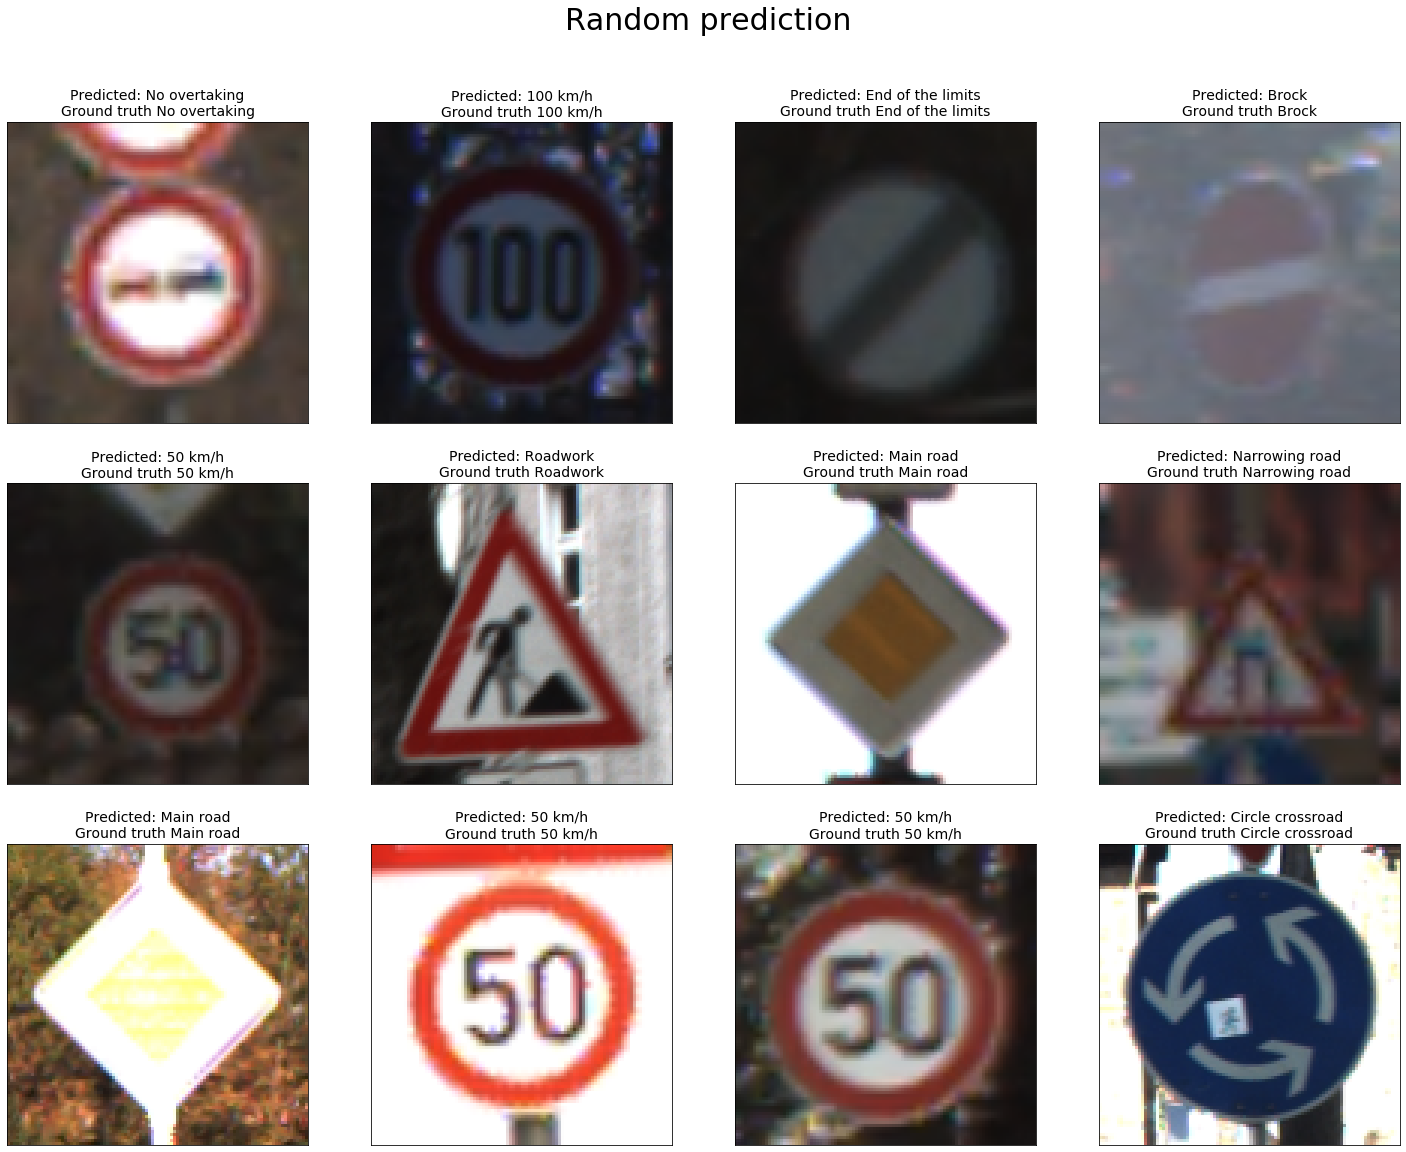

In [12]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 8))
visualize = trainDf.sample(rows*cols)

analys_df_copy = analys_df.copy()
analys_df_copy = analys_df_copy.sample(frac=1)

idx = 0
for i in range(rows):
    for j in range(cols):
        img = cv2.imread(analys_df_copy.iloc[idx]['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100, 100))
        
        gt = analys_df_copy.iloc[idx]['gt']
        pred = analys_df_copy.iloc[idx]['prediction']
        
        axs[i,j].imshow(img)
        axs[i,j].set_title('Predicted: {}\nGround truth {}'.format(labels[pred], labels[gt]), fontsize=14)
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1
        
fig.suptitle("Random prediction", fontsize=30, y=2.1, x=0.515);
plt.subplots_adjust(left=None, bottom=None, right=0.9, top=1.9, wspace=None, hspace=None)

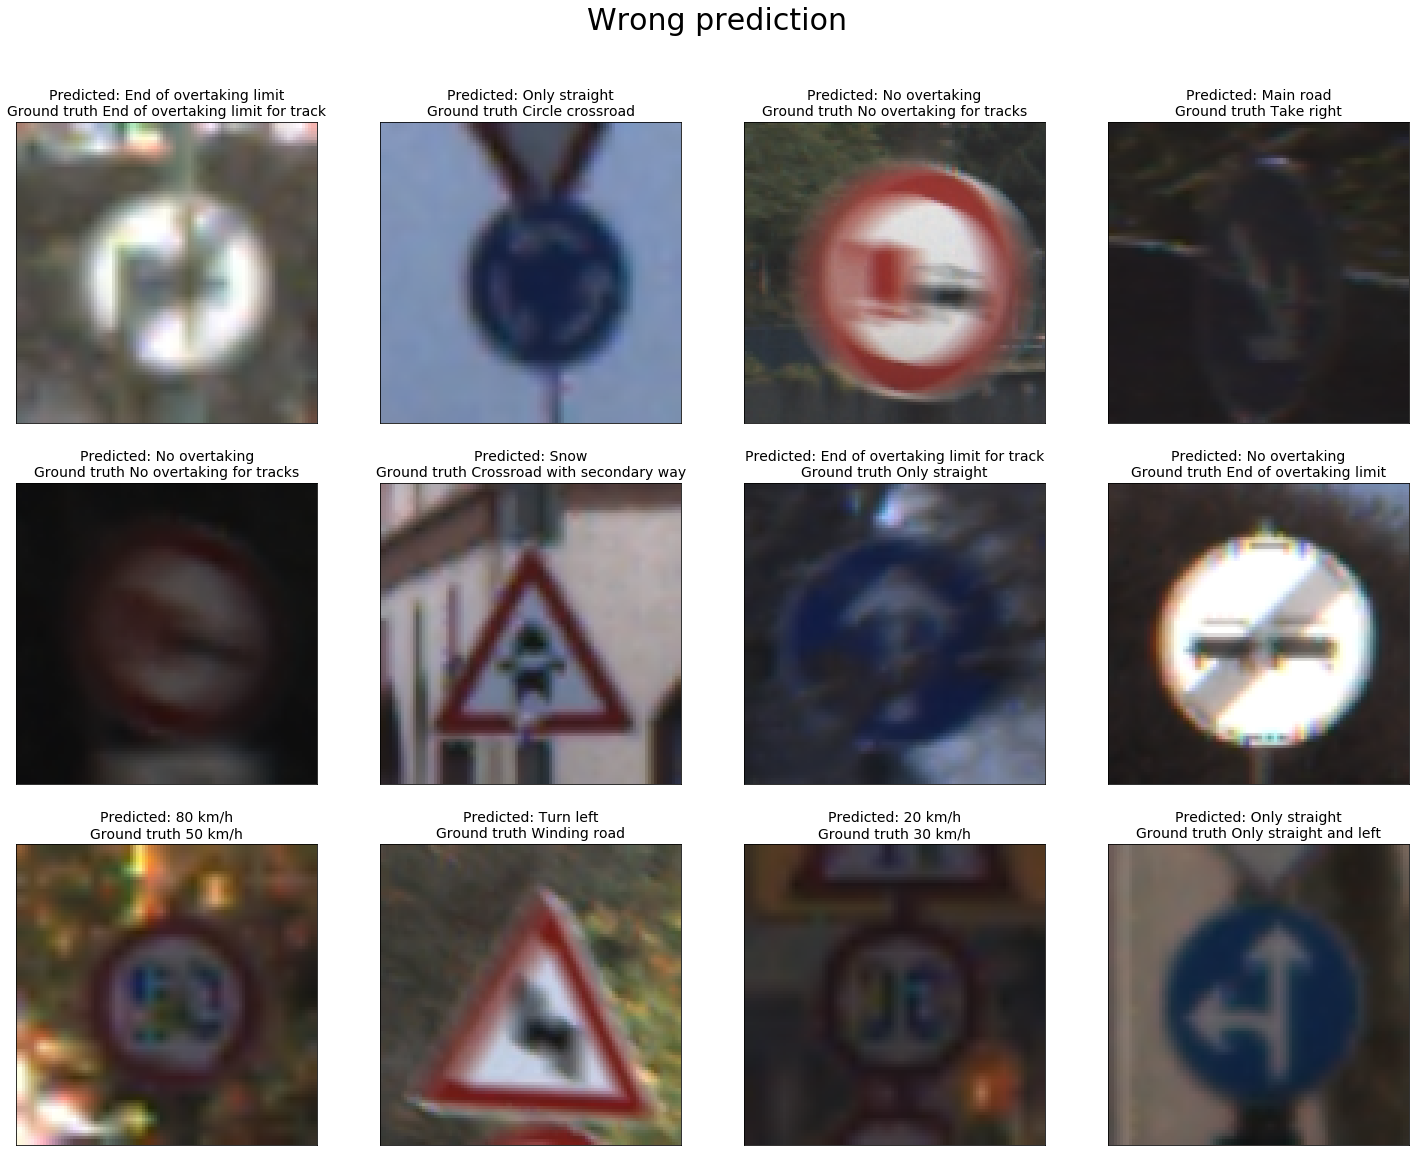

In [13]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 8))
visualize = trainDf.sample(rows*cols)

analys_df_copy = analys_df[analys_df['prediction_type'] == 'Wrong'].copy()
analys_df_copy = analys_df_copy.sample(frac=1)

idx = 0
for i in range(rows):
    for j in range(cols):
        img = cv2.imread(analys_df_copy.iloc[idx]['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100, 100))
        
        gt = analys_df_copy.iloc[idx]['gt']
        pred = analys_df_copy.iloc[idx]['prediction']
        
        axs[i,j].imshow(img)
        axs[i,j].set_title('Predicted: {}\nGround truth {}'.format(labels[pred], labels[gt]), fontsize=14)
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1
        
fig.suptitle("Wrong prediction", fontsize=30, y=2.1, x=0.515);
plt.subplots_adjust(left=None, bottom=None, right=0.9, top=1.9, wspace=None, hspace=None)

In [14]:
output_dir = './output'
error_dir = './output/errors'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
if not os.path.isdir(error_dir):
    os.mkdir(error_dir)

for idx, row in tqdm.tqdm_notebook(analys_df[analys_df['prediction_type'] == 'Wrong'].iterrows()):
    name = os.path.splitext(os.path.basename(row['image']))[0]
    name = '{}__{}__as__{}.png'.format(name, labels[row['gt']].replace(' ', '_'), labels[row['prediction']].replace(' ', '_'))
    img = cv2.imread(row['image'])
    cv2.imwrite(os.path.join(error_dir, name), img)

In [15]:
!tar -cvf ./errors.tar ./output/errors 1>/dev/null

The system cannot find the path specified.


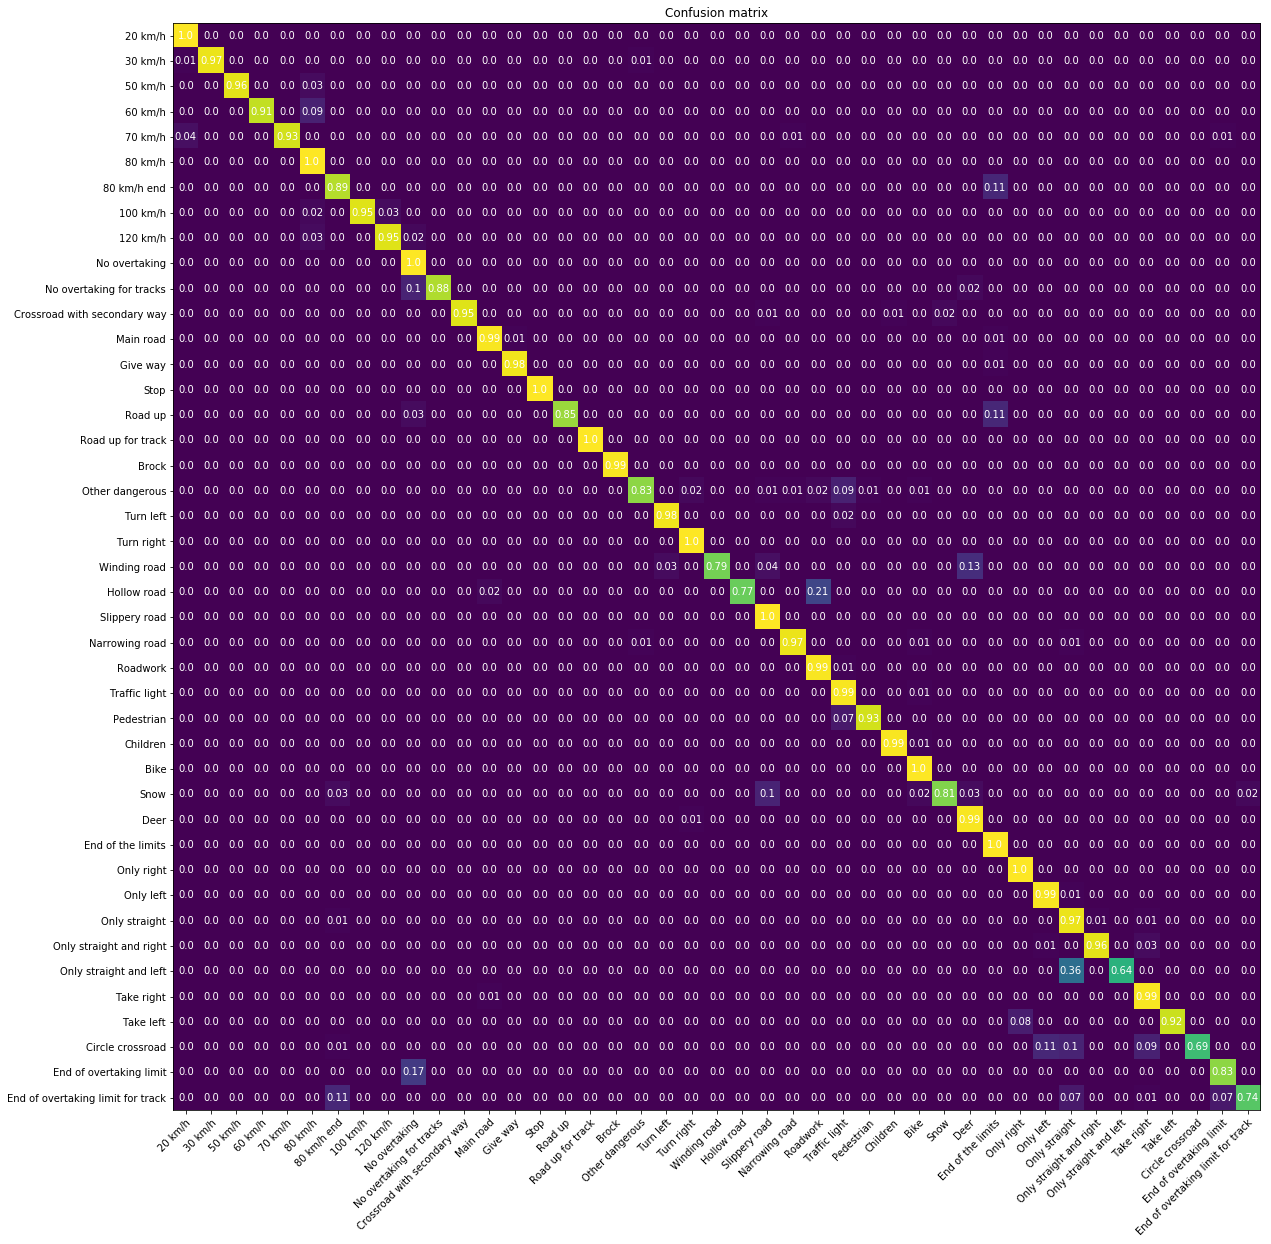

In [16]:
cm = confusion_matrix
f = np.sum(cm, axis=1)
normalized_cm = cm
for i in range(43):
    normalized_cm[i, :] /= sum(normalized_cm[i, :])

normalized_cm = np.round(normalized_cm, 2)
    
fig, ax = plt.subplots(1,1, figsize=((20, 20)))

ax.imshow(normalized_cm)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(labels)):
   for j in range(len(labels)):
       ax.text(j, i, normalized_cm[i, j], ha="center", va="center", color="w")

ax.set_title('Confusion matrix');

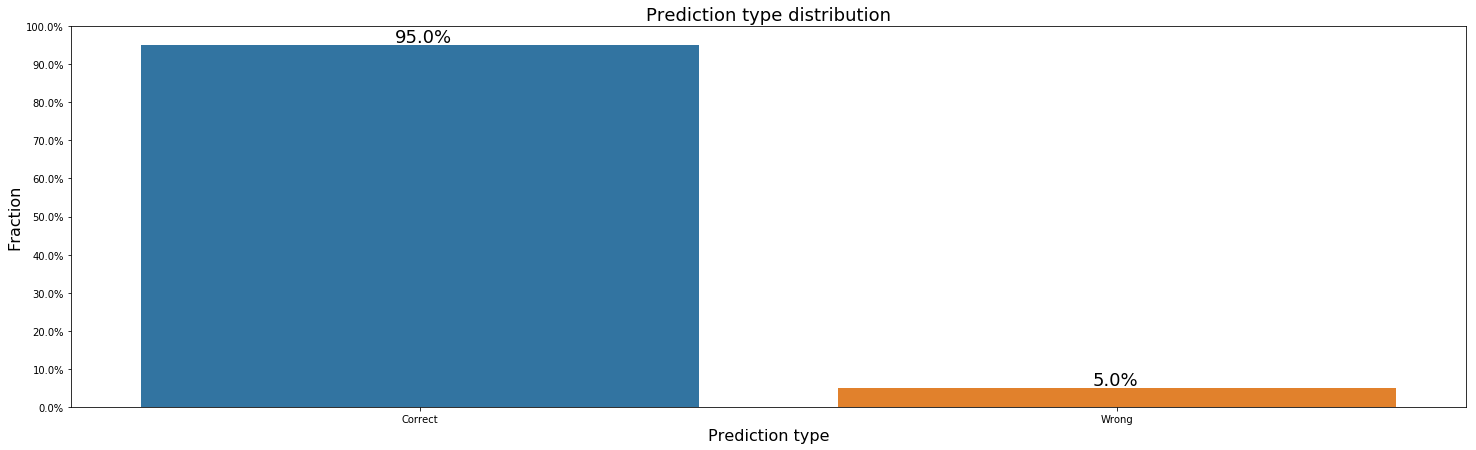

In [17]:
fig, axs = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(25, 7))

px = sns.countplot(x='prediction_type', data=analys_df, ax=axs)
axs.set_title('Prediction type distribution', fontsize=18)
axs.set_xlabel('Prediction type', fontsize=16)
axs.set_ylabel('Fraction', fontsize=16);


total = analys_df.shape[0]
for idx, p in enumerate(px.patches):
        px.annotate('{:.1f}%'.format(p.get_height()/total*100), (p.get_x()+0.365, p.get_height()+100), fontsize=18)


px.yaxis.set_ticks(np.linspace(0, total, 11))
px.set_yticklabels(map('{:.1f}%'.format, 100*px.yaxis.get_majorticklocs()/total));

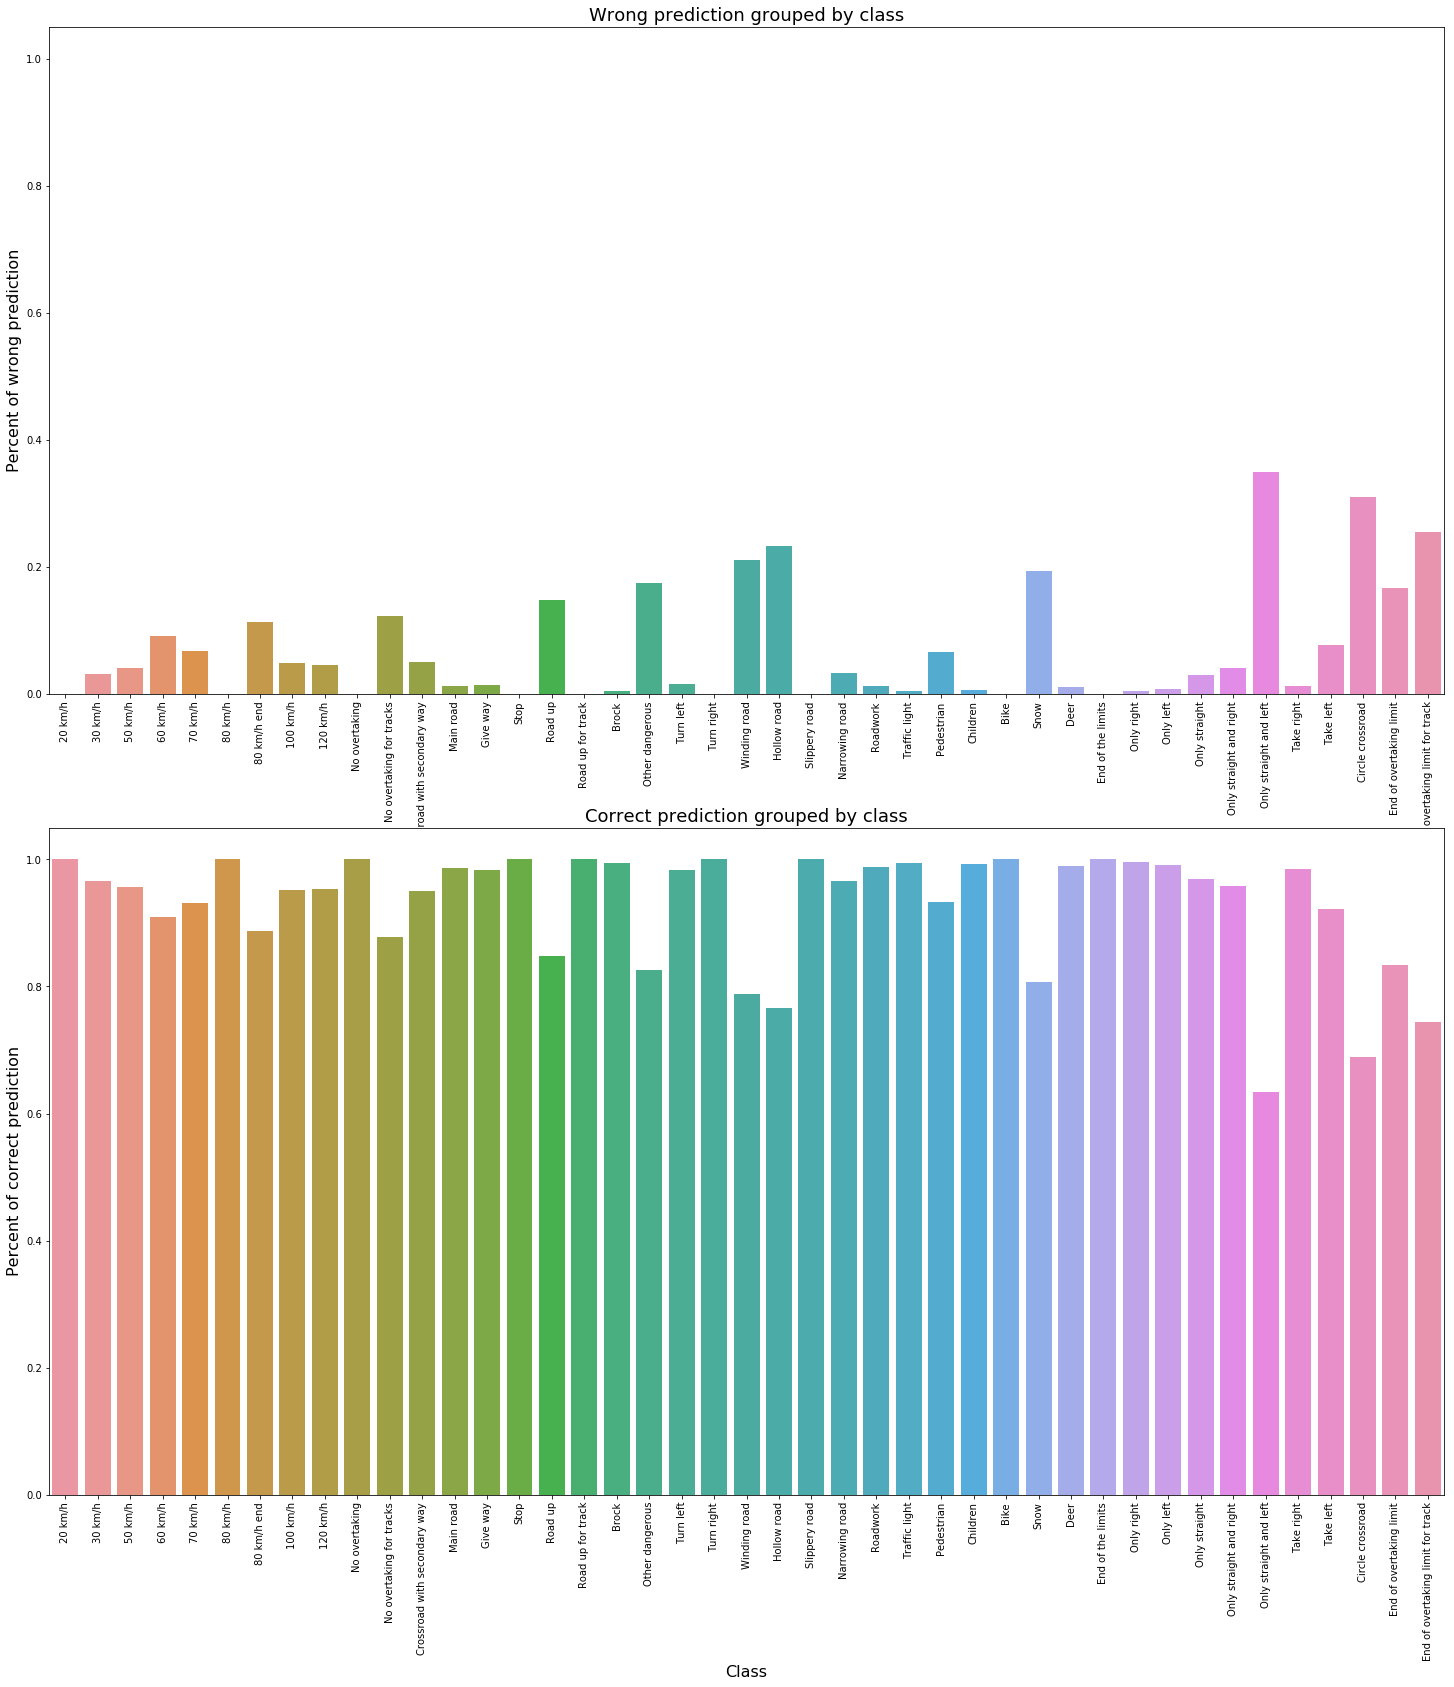

In [18]:
correct_prediction_by_class = analys_df[analys_df['prediction_type'] == 'Correct']['gt'].value_counts() / testDf['ClassId'].value_counts().sort_index()
correct_prediction_by_class_df = pd.DataFrame({'accuracy': correct_prediction_by_class, 'class': labels})

wrong_prediction_by_class = analys_df[analys_df['prediction_type'] == 'Wrong']['gt'].value_counts() / testDf['ClassId'].value_counts().sort_index()
wrong_prediction_by_class_df = pd.DataFrame({'error': wrong_prediction_by_class, 'class': labels})

fig, axs = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(25, 27))

sns.barplot(x='class', y='accuracy', data=correct_prediction_by_class_df, ax=axs[1])
sns.barplot(x='class', y='error', data=wrong_prediction_by_class_df, ax=axs[0])

axs[0].set_title('Wrong prediction grouped by class', fontsize=18)
axs[0].set_xlabel('Class', fontsize=16)
axs[0].set_ylabel('Percent of wrong prediction', fontsize=16)
axs[0].set_xticklabels(rotation=90, labels=labels)

axs[1].set_title('Correct prediction grouped by class', fontsize=18)
axs[1].set_xlabel('Class', fontsize=16)
axs[1].set_ylabel('Percent of correct prediction', fontsize=16)
axs[1].set_xticklabels(rotation=90, labels=labels);

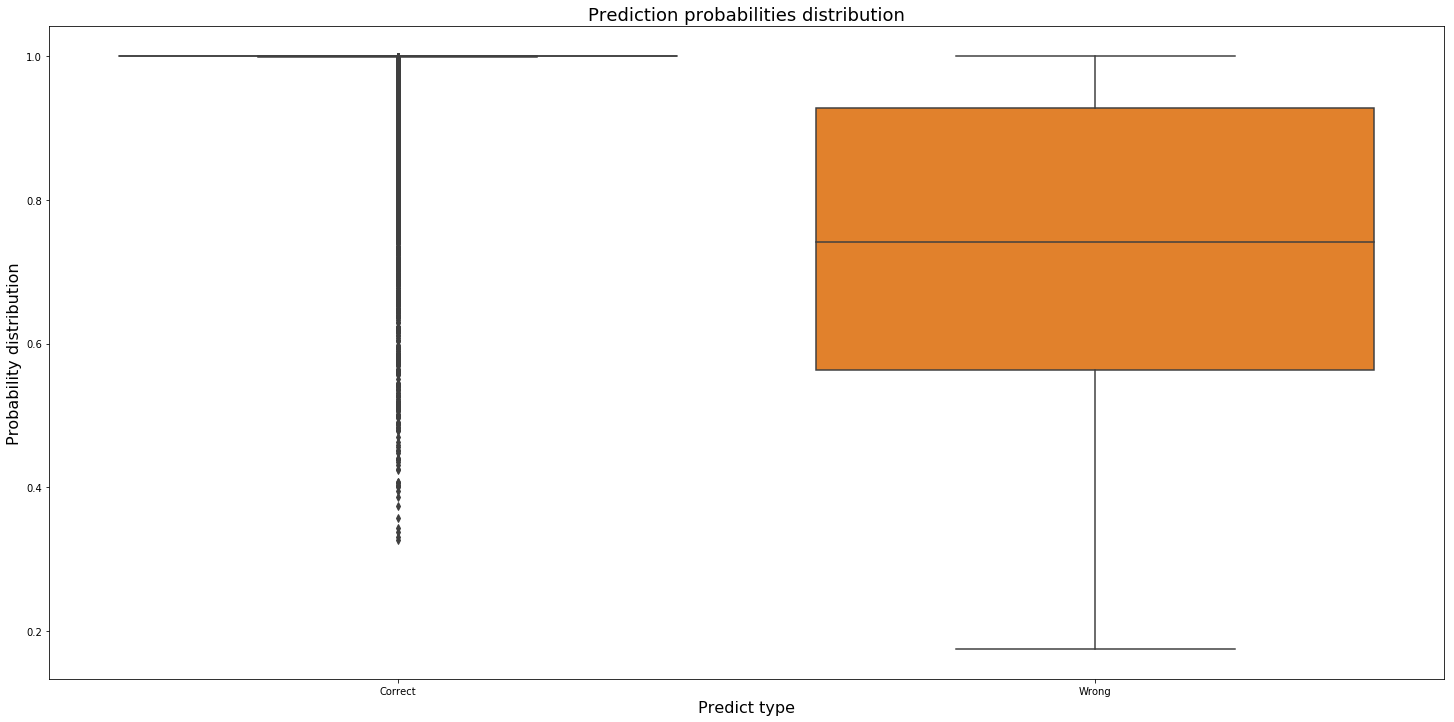

In [19]:
fig, axs = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(25,12))

sns.boxplot(x='prediction_type', y='prediction_probas', data=analys_df, ax=axs);
axs.set_title('Prediction probabilities distribution', fontsize=18);
axs.set_xlabel('Predict type', fontsize=16)
axs.set_ylabel('Probability distribution', fontsize=16);

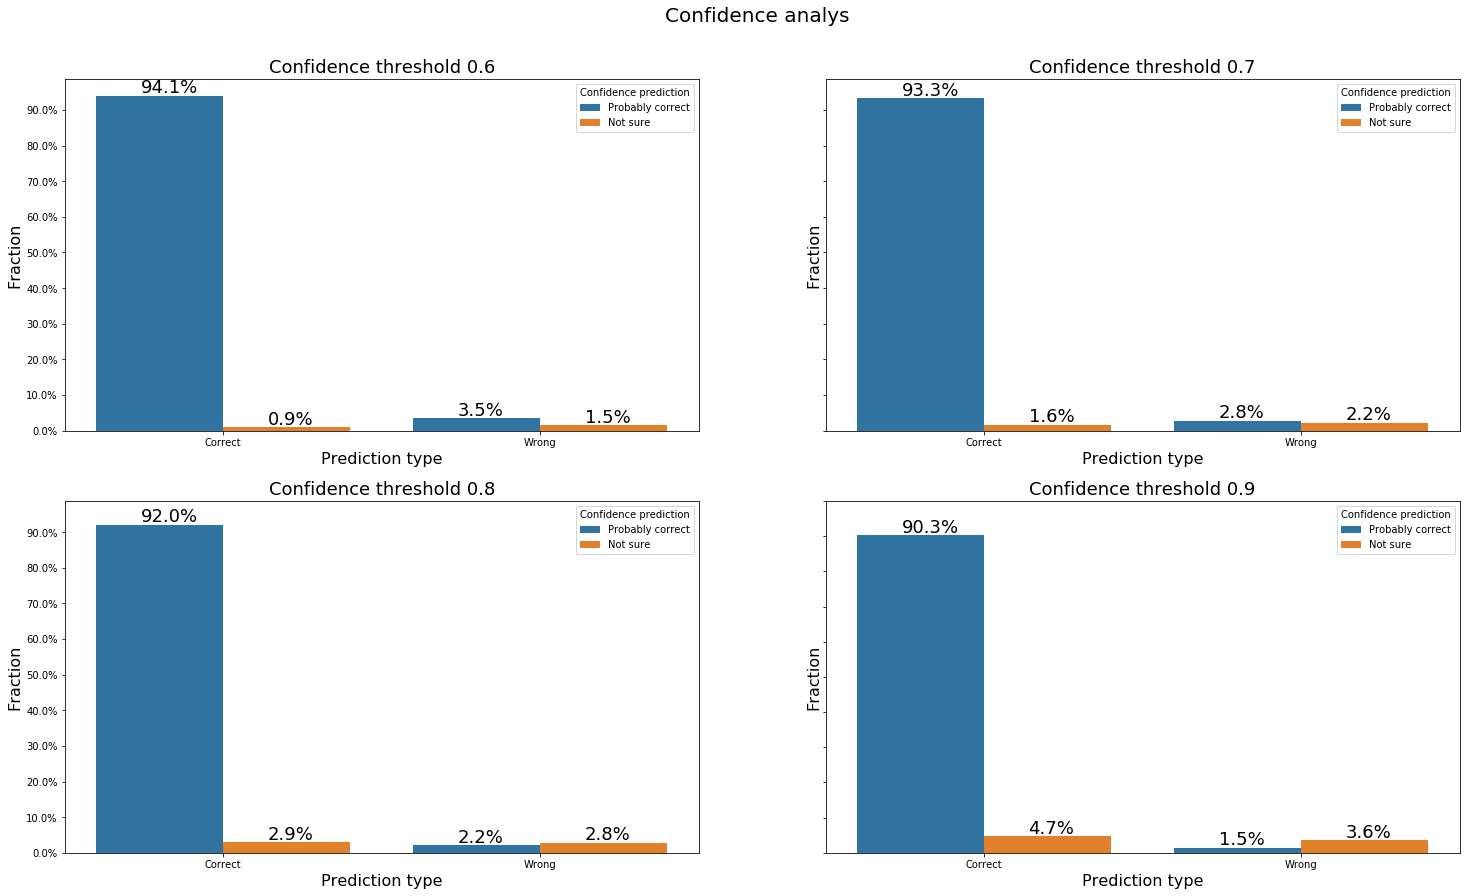

In [20]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=True, figsize=(25,10))

confidence_thresholds = iter([0.6, 0.7, 0.8, 0.9])

for i in range(2):
    for j in range(2):
        confidence_threshold = next(confidence_thresholds)
        
        analys_df_confidence = analys_df.copy()
        new_predict = []
        for idx, row in analys_df_confidence.iterrows():
            new_predict.append('Not sure' if row['prediction_probas'] < confidence_threshold else 'Probably correct')

        analys_df_confidence['confidence_analys'] = new_predict
        
        axs = axes[i,j]
        
        px = sns.countplot(x='prediction_type', hue='confidence_analys', data=analys_df_confidence, ax=axs);
        axs.set_title('Confidence threshold {}'.format(confidence_threshold), fontsize=18)
        axs.set_xlabel('Prediction type', fontsize=16)
        axs.set_ylabel('Fraction', fontsize=16);
        axs.legend(title='Confidence prediction')

        total = analys_df_confidence.shape[0]
        for idx, p in enumerate(px.patches):
            px.annotate('{:.1f}%'.format(p.get_height()/total*100), (p.get_x()+0.14, p.get_height()+100), fontsize=18)


        px.yaxis.set_ticks(np.linspace(0, total, 11))
        px.set_yticklabels(map('{:.1f}%'.format, 100*px.yaxis.get_majorticklocs()/total));

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.2, wspace=None, hspace=None)
fig.suptitle('Confidence analys', fontsize=20, y=1.3, x=0.51);

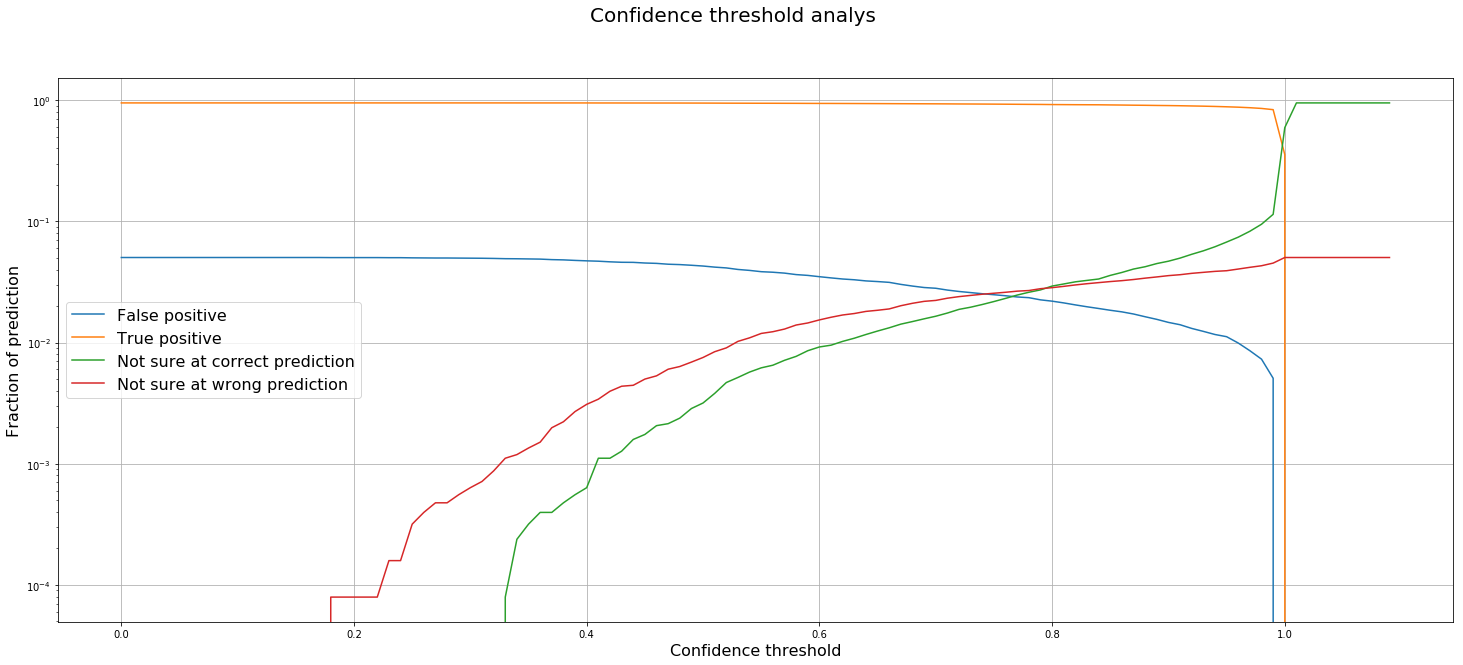

In [11]:
confidences = []

for confidence_threshold in tqdm.tqdm_notebook(np.arange(start=0, stop=1.1, step=0.01)):

    analys_df_confidence = analys_df.copy()
    new_predict = []
    for idx, row in analys_df_confidence.iterrows():
        new_predict.append('Not sure' if row['prediction_probas'] < confidence_threshold else 'Probably correct')

    analys_df_confidence['confidence_analys'] = new_predict

    false_positive = analys_df_confidence[(analys_df_confidence['prediction_type'] == 'Wrong') &
                                          (analys_df_confidence['confidence_analys'] == 'Probably correct')].shape[0]/analys_df_confidence.shape[0]
    
    true_positive = analys_df_confidence[(analys_df_confidence['prediction_type'] == 'Correct') &
                                          (analys_df_confidence['confidence_analys'] == 'Probably correct')].shape[0]/analys_df_confidence.shape[0]
    
    not_sure_at_wrong = analys_df_confidence[(analys_df_confidence['prediction_type'] == 'Wrong') &
                                          (analys_df_confidence['confidence_analys'] == 'Not sure')].shape[0]/analys_df_confidence.shape[0]
    
    not_sure_at_correct = analys_df_confidence[(analys_df_confidence['prediction_type'] == 'Correct') &
                                          (analys_df_confidence['confidence_analys'] == 'Not sure')].shape[0]/analys_df_confidence.shape[0]
    
    cf_level_result = {'fp': false_positive, 'tp': true_positive, 'ns_w': not_sure_at_wrong, 'ns_c': not_sure_at_correct, 'cf': confidence_threshold}
    confidences.append(cf_level_result)
    
confidences = pd.DataFrame(confidences)

fig, axes = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(25,10))


sns.lineplot(x='cf', y='fp', data=confidences, ax=axes, label='False positive');
sns.lineplot(x='cf', y='tp', data=confidences, ax=axes, label='True positive');
sns.lineplot(x='cf', y='ns_c', data=confidences, ax=axes, label='Not sure at correct prediction');
sns.lineplot(x='cf', y='ns_w', data=confidences, ax=axes, label='Not sure at wrong prediction');

axes.set_yscale('log')
axes.set_xlabel('Confidence threshold', fontsize=16)
axes.set_ylabel('Fraction of prediction', fontsize=16);
axes.legend(loc='center left', prop={'size': 16})
fig.suptitle('Confidence threshold analys', fontsize=20);
plt.grid()

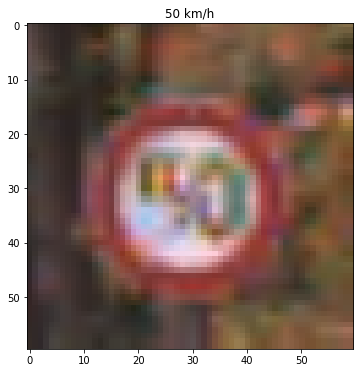

In [23]:
import matplotlib.gridspec as gridspec
res = sess.run([load_img, load_label, conv1, conv2, conv3, conv4, conv5, conv6],
               feed_dict={dp_rate: 0,
                          manual_load: False,
                          img_placeholder: np.zeros([12,60,60,3])})
img, label = res[0], res[1]
img_visible = (img*255).astype(np.uint8)[0, :, :, :]
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(img_visible)
ax.set_title(labels[label[0]])

filters = res[2:]
layer_names = ['Convolutional layer {}'.format(x+1) for x in range(len(filters))]

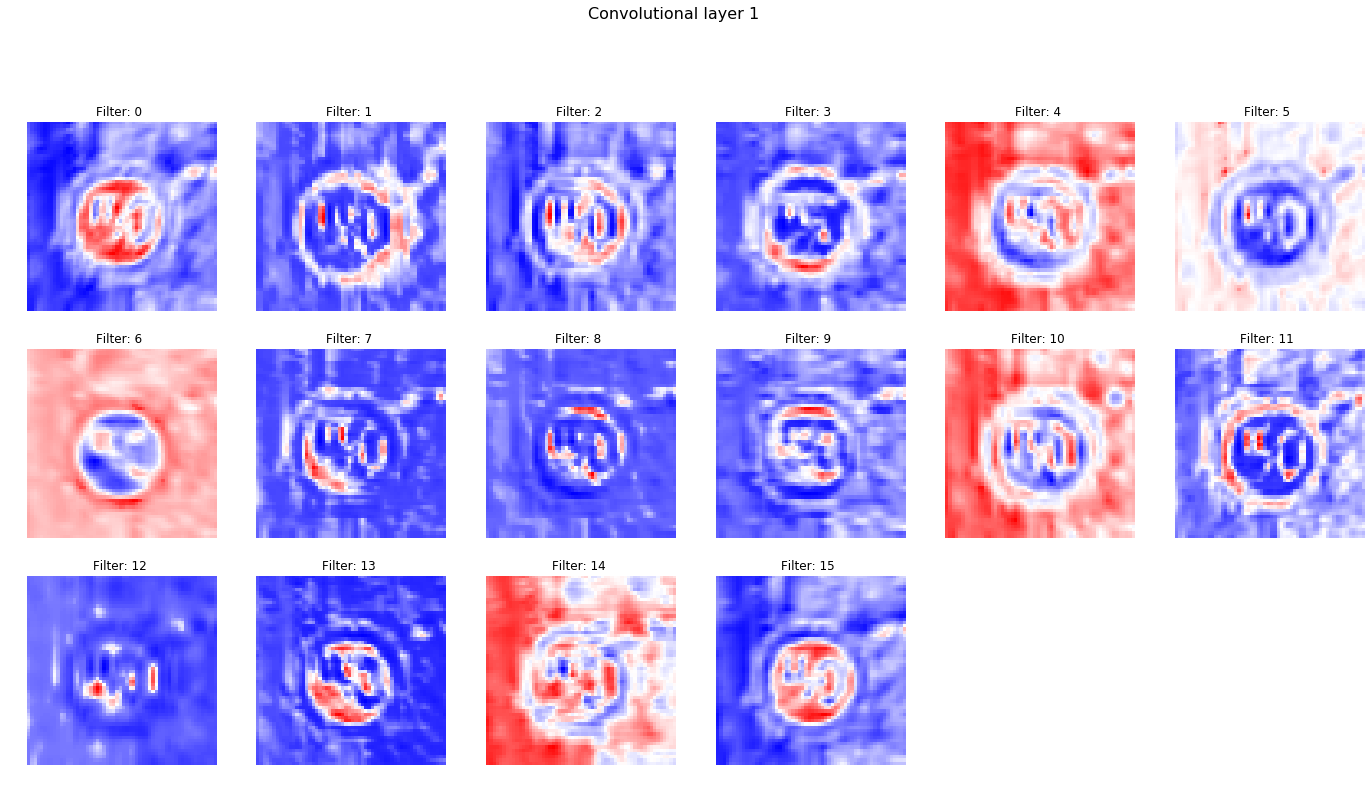

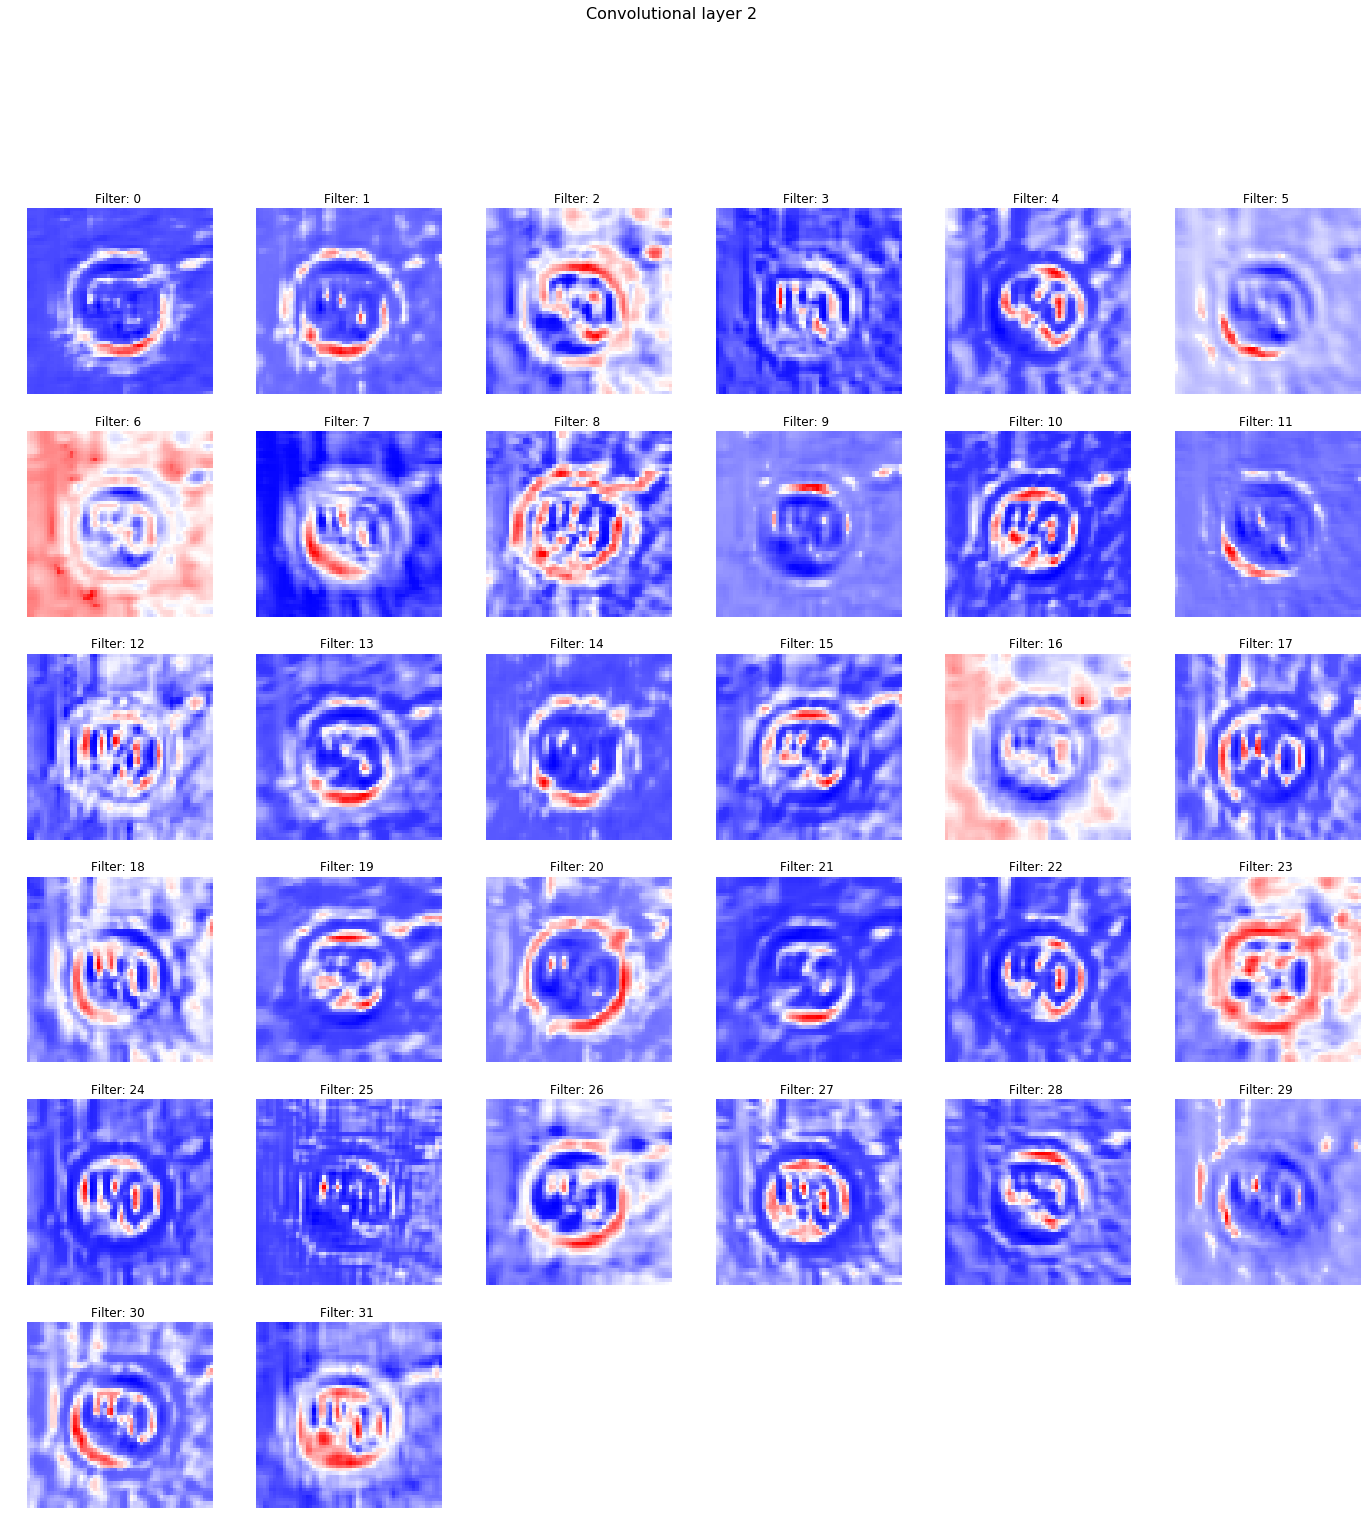

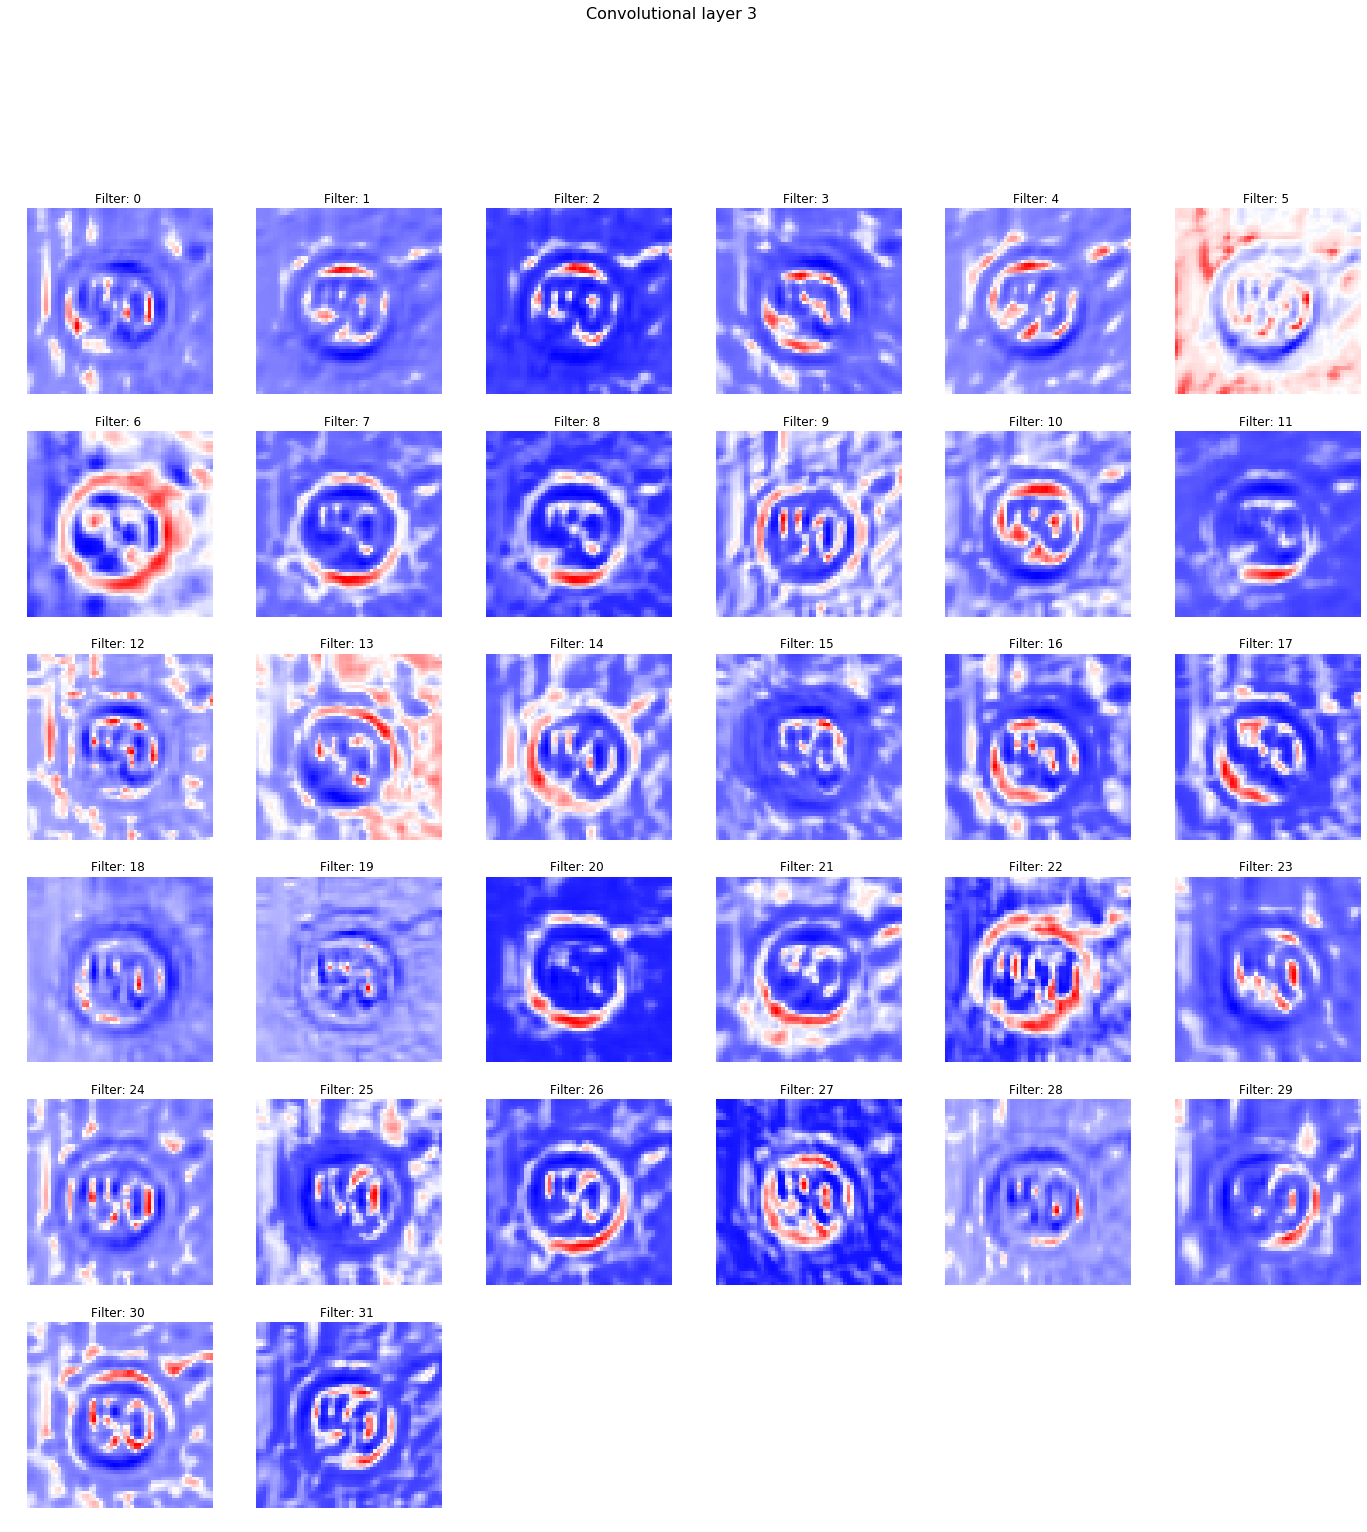

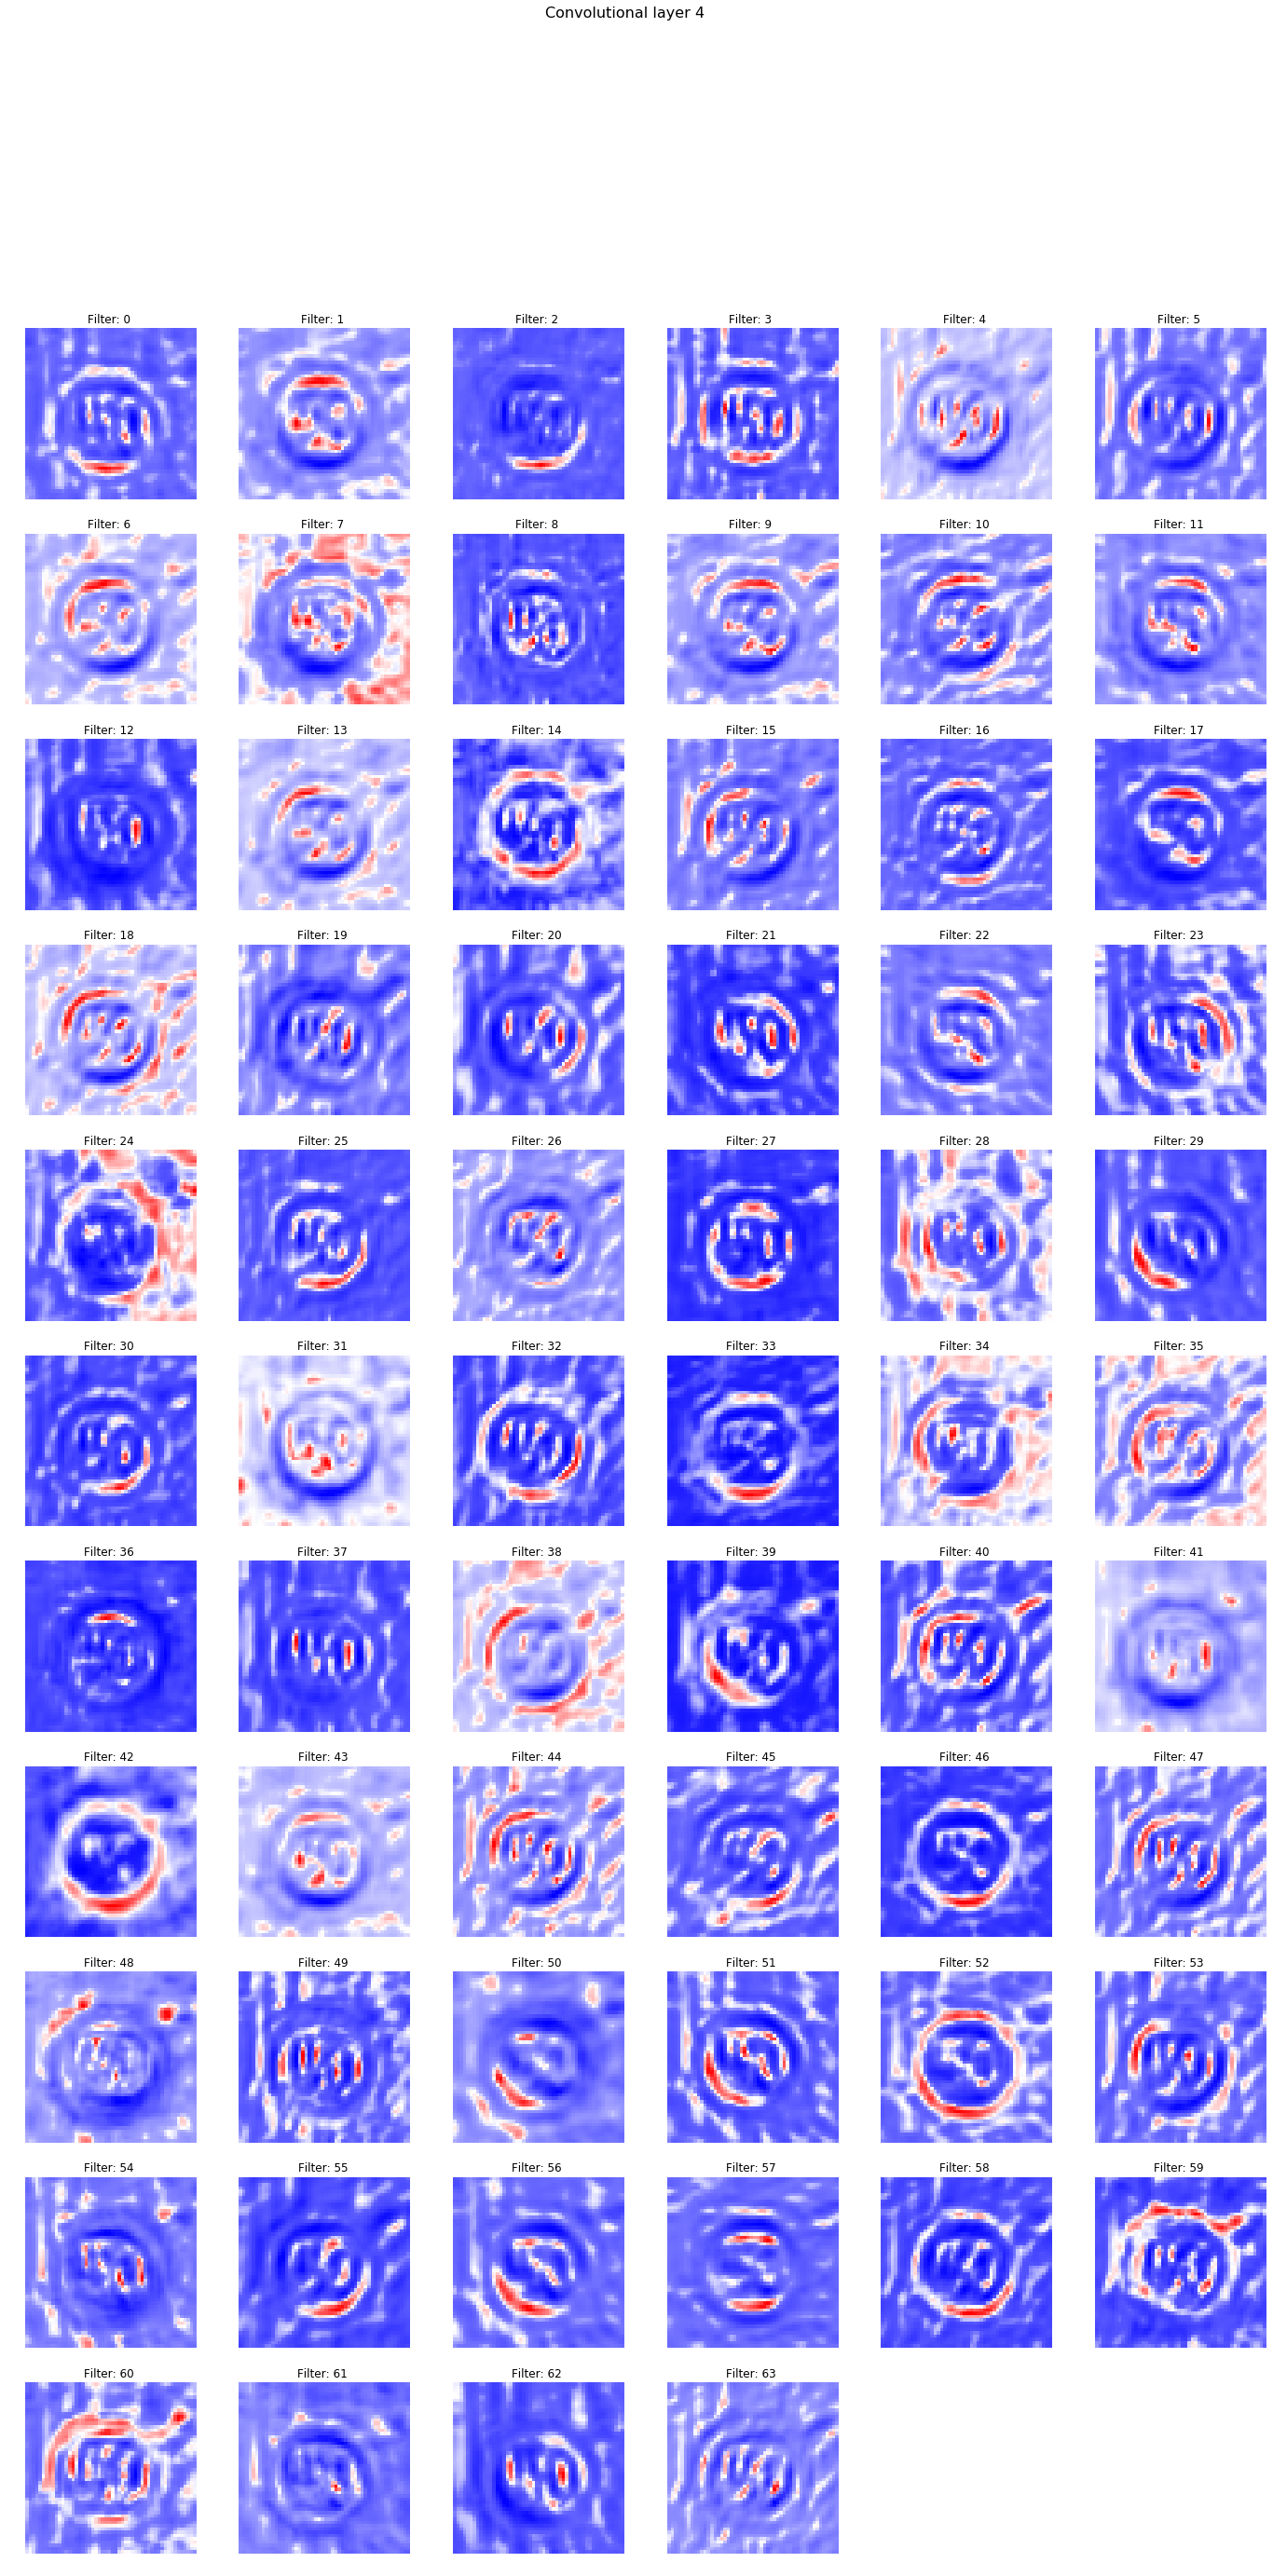

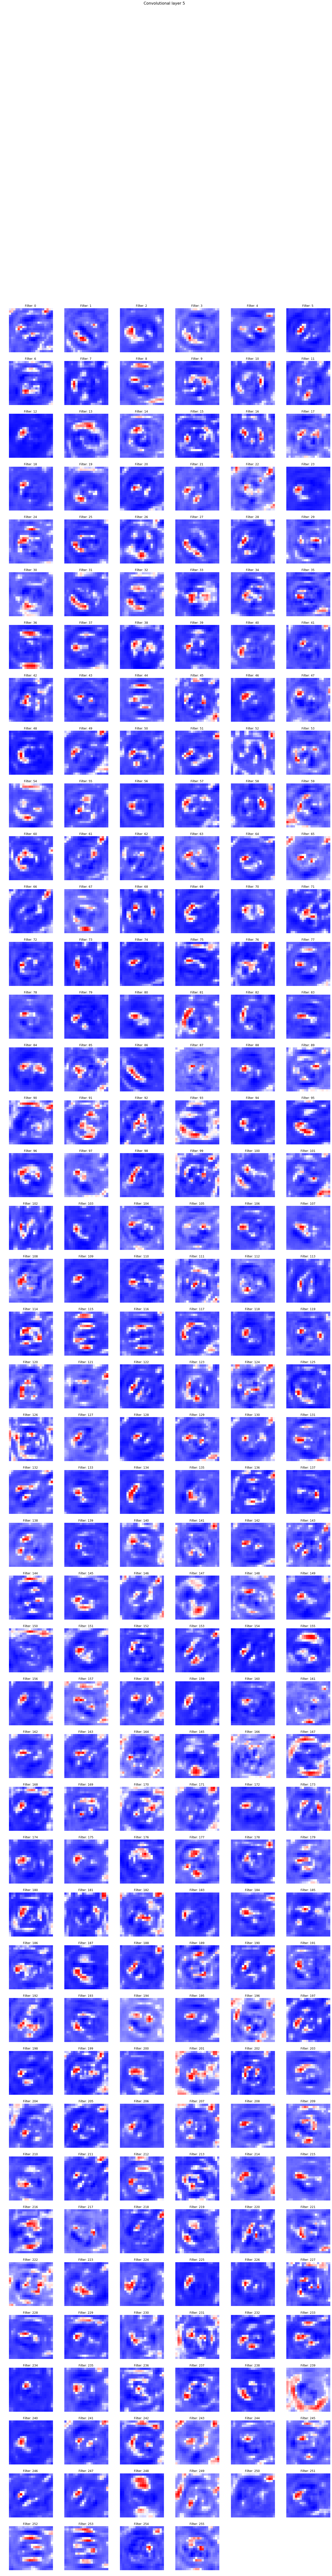

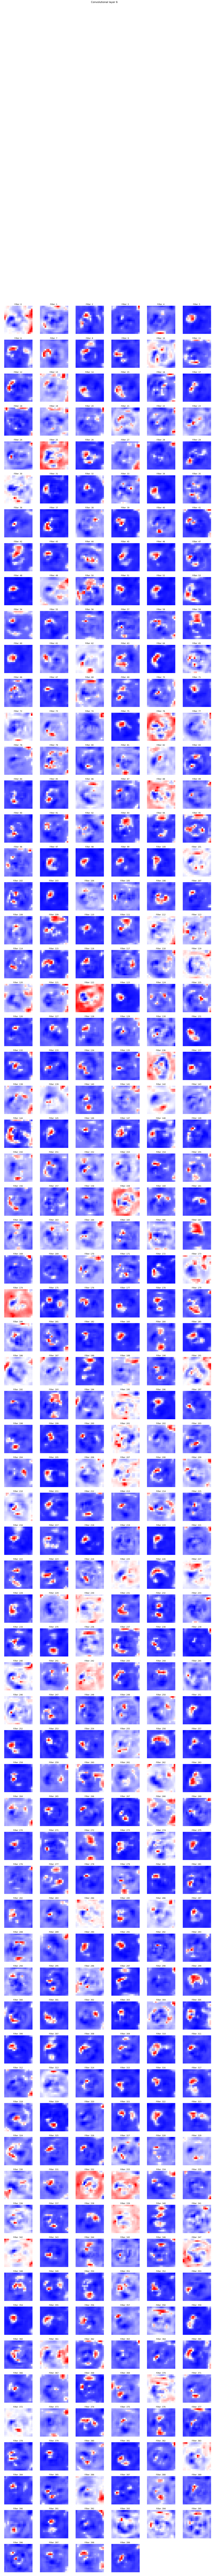

In [24]:
for filter_index in range(len(filters)):
    layers = filters[filter_index]
    filter_count = layers.shape[3]
    n_columns = 6
    n_rows = math.ceil(filter_count / n_columns) + 1
    fig = plt.figure(figsize=(24,n_rows*4));
    fig.suptitle(layer_names[filter_index], fontsize=16)
    for i in range(filter_count):
        plt.subplot(n_rows, n_columns, i+1)
        plt.axis('off')
        plt.title('Filter: {0} '.format(str(i)))
        plt.imshow(layers[0,:,:,i], interpolation="nearest", cmap='bwr')
    plt.show()



In [25]:
def grad_cam(sess, layer, predicted_class, nb_classes, img):
    conv_layer = layer
    one_hot = tf.sparse_to_dense(predicted_class, [nb_classes], 1.0)
    signal = tf.multiply(logits, one_hot)
    loss = tf.reduce_mean(signal)
    
    grads = tf.gradients(loss, conv_layer)[0]
    # Normalizing the gradients
    norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads))) + tf.constant(1e-5))

    output, grads_val = sess.run([conv_layer, norm_grads], feed_dict={dp_rate: 0, manual_load: True,
                                                                     img_placeholder: img})
    output = output[0]           
    grads_val = grads_val[0]     

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    # Taking a weighted average
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    # Passing through ReLU
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, (224,224))

    # Converting grayscale to 3-D
    cam3 = np.expand_dims(cam, axis=2)
    cam3 = np.tile(cam3,[1,1,3])

    return cam3

W0410 11:18:45.398692  4640 deprecation.py:323] From <ipython-input-25-120dd8821b42>:3: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W0410 11:18:45.605833  4640 deprecation.py:323] From <ipython-input-25-120dd8821b42>:9: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


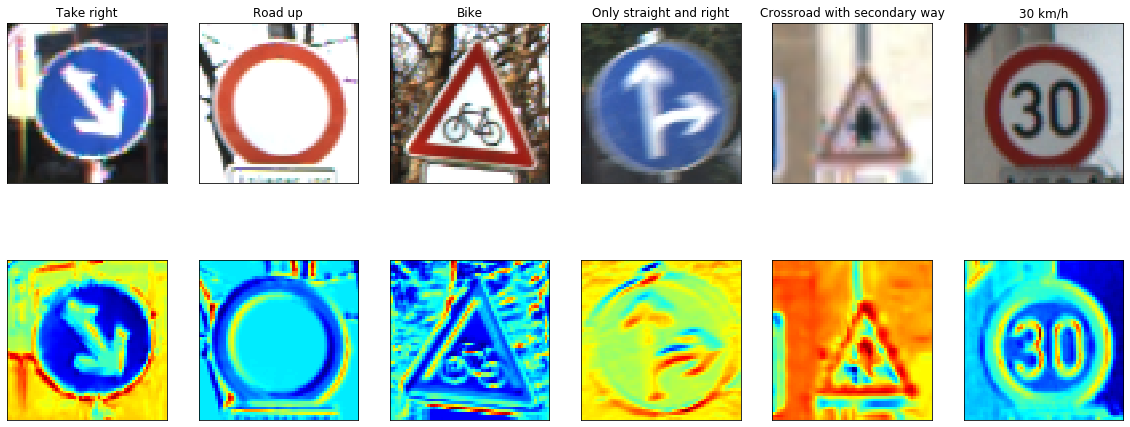

In [26]:
_img, _lb = sess.run([load_img, load_label])
grad_ipt = _img.copy()

samples = _img.shape[0]//2
fig, ax = plt.subplots(ncols=samples, nrows=2, figsize=(20, 8))
for i in range(samples):
    ax[0, i].imshow(_img[i, :, :, :])
    ax[0, i].get_xaxis().set_visible(False)
    ax[0, i].get_yaxis().set_visible(False)
    ax[0, i].set_title(labels[_lb[i]])
    
    image = _img[i, :, :, :]
    
    height = image.shape[0]
    width = image.shape[1]

    grad_ipt[0, :, :] = _img[i, :, :]
    heat_map = grad_cam(sess, conv1, _lb[i], 43, grad_ipt)
    # resize heat map
    heat_map_resized = cv2.resize(heat_map, (height, width))

    # normalize heat map
    max_value = np.max(heat_map_resized)
    min_value = np.min(heat_map_resized)
    normalized_heat_map = (heat_map_resized - min_value) / (max_value - min_value)
    normalized_heat_map = cv2.applyColorMap((normalized_heat_map*255).astype(np.uint8), cv2.COLORMAP_JET)
    
    ax[1, i].imshow(normalized_heat_map)
    ax[1, i].get_xaxis().set_visible(False)
    ax[1, i].get_yaxis().set_visible(False)